### **Преамбула**

**Навыки продемонстрированные в данной работе:**

* Bootstrap;
* Формулирование и тестирование статистических гипотез;
* Работа с выбросами (коэффициент медианной асимметрии);
* Работа с ненормально распределенными данными;
* ABC-анализ;
* Визуализация (3d scatter plots, density plots, boxplot (violin), pie charts, bar plots, heatmap).

**Кейс:**

Проект «Московское долголетие» стартовал в 2018 году. Он предоставляет московским пенсионерам возможность бесплатно посещать различные занятия и мероприятия в онлайн и очном (оффлайн) форматах. Цель проекта - помочь пожилым людям оставаться активными, сохранить здоровье и продлить жизнь. В рамках проекта «Московское долголетие» москвичи старшего возраста (55+ для женщин и 60+ для мужчин) имеют возможность заниматься различными видами спорта, изучать иностранные языки, приобретать новые навыки и знания. Проект также помогает пожилым людям найти новых друзей, способствует общению с ними и тем самым повышает уровень социализации. В наборе данных содержится информация о людях, записавшихся в программу, и о занятиях, которые они посещали в период с 1 апреля 2022 года по 28 февраля 2023 года. За этот период было проведено более 600 тысяч групповых занятий онлайн и очно; в наборе данных представлена выборка участников программы, которые могли посещать эти занятия. 

Используя полученные данные, попытайтесь ответить на следующий вопрос и представить один (или несколько) наглядный пример для описания этого явления (с помощью основных диаграмм или/и графиков):   
$$\begin{aligned}\textbf{"Как мы можем увеличить посещаемость занятий и/или привлечь больше участников в программу 'Московское долголетие'?".}\end{aligned}$$

### **Импорты и настройка**

In [1]:
import pandas as pd
import numpy as np

from pingouin import corr
from scipy.interpolate import make_interp_spline
from statsmodels.stats.stattools import medcouple
from statsmodels.stats.weightstats import ztest
import scipy.stats as stats

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from datetime import datetime

import warnings

Настраиваем общий стиль для графиков по умолчанию

In [2]:
plt.style.use('ggplot')

Настраиваем отображение данных в pandas

In [3]:
pd.set_option('display.max_columns', 40)
pd.set_option('display.float_format', '{:.4f}'.format)

Отключаем предупреждения

In [4]:
warnings.simplefilter(action='ignore', category='Warning')

### **Загрузка и описание датасета**

In [5]:
df = pd.read_excel('data/data_msk.xlsx')

Одна строка в наборе данных - это описание одного участника программы. Информация о нем содержится в следующих переменных:
* id - идентификатор участника
* registration_date - дата регистрации в программе (формат ГГГГ-ММ-ДД)
* age - возраст участника (через регистрацию)
* gender - женский или мужской
* birth_date - дата рождения участника (формат ГГГГ-ММ-ДД)
* num_participate - количество посещенных занятий за период наблюдения, целое число
* num_online_participate - количество онлайн-занятий, посещенных за период наблюдения, целое число
* days_activity - дни в период наблюдения, в течение которых участник посещал занятия, целое число
* num_activities - количество мероприятий (уникальных направлений), посещенных за период наблюдения, целое число
* 2022-04 ... 2023-02 - количество посещенных занятий за соответствующий месяц, целое число
* 2022-04_online ... 2023-02_online - количество посещенных онлайн-занятий за соответствующий месяц, целое число
* top1_activity_name - первый (Top-1) наиболее часто посещаемый тип занятий, строка (онлайн-занятия отмечены префиксом 'ONLINE')
* top1_activity_participate - количество посещений первого наиболее часто посещаемого курса, целое число
* top2_activity_name - второй (Top-2) наиболее часто посещаемый тип занятий, строка (онлайн-занятия, отмеченные префиксом 'ONLINE ')
* top2_activity_participate - количество посещений второго по частоте курса обучения, целое число
* top3_activity_name - третий (Top-3) наиболее часто посещаемый тип занятий, строка (онлайн-занятия, отмеченные префиксом 'ONLINE ')
* top3_activity_participate - количество посещений третьего по частоте курса обучения, целое число

In [6]:
df.head()

,id,registration_date,age,gender,birth_date,num_participate,num_online_participate,days_activity,num_activities,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,2022-04_online,2022-05_online,2022-06_online,2022-07_online,2022-08_online,2022-09_online,2022-10_online,2022-11_online,2022-12_online,2023-01_online,2023-02_online,top1_activity_name,top1_activity_participate,top2_activity_name,top2_activity_participate,top3_activity_name,top3_activity_participate
0,101391104,2019-02-26,64,female,1959-09-10,134.0000,59,124,5,24,12,9,16,22,11,9,7,7,11,6,14,6,3,10,6,6,3,3,3,5,0,ONLINE English language,51,General physical training,30,"Fitness, exercise equipment",25
1,101437383,2022-09-14,65,female,1958-06-29,80.0000,0,72,3,0,0,0,0,0,0,11,15,13,21,20,0,0,0,0,0,0,0,0,0,0,0,Gymnastics,76,Dancing,3,"History, art, local history",1
2,101351338,2018-03-19,67,female,1956-08-28,27.0000,13,24,4,0,0,0,0,0,7,4,6,10,0,0,0,0,0,0,0,7,4,2,0,0,0,ONLINE Drawing,13,Gymnastics,10,Dancing,2
3,101354578,2018-03-22,84,female,1939-05-19,134.0000,94,106,9,20,23,1,0,0,2,4,19,21,18,26,15,19,1,0,0,0,2,12,12,13,20,ONLINE Gymnastics,39,ONLINE Live well,29,Information technology,16
4,101411997,2019-12-17,72,female,1951-03-02,76.0000,76,63,2,4,1,13,9,11,14,11,5,3,0,5,4,1,13,9,11,14,11,5,3,0,5,ONLINE Drawing,72,ONLINE Educational workshop,4,NaN,0


### **Работаем со структурой данных и оформляем датасет**

#### Избавляемся от пропусков

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52334 entries, 0 to 52333
Data columns (total 37 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         52334 non-null  int64  
 1   registration_date          52334 non-null  object 
 2   age                        52334 non-null  int64  
 3   gender                     52334 non-null  object 
 4   birth_date                 52334 non-null  object 
 5   num_participate            50906 non-null  float64
 6   num_online_participate     52334 non-null  int64  
 7   days_activity              52334 non-null  int64  
 8   num_activities             52334 non-null  int64  
 9   2022-04                    52334 non-null  int64  
 10  2022-05                    52334 non-null  int64  
 11  2022-06                    52334 non-null  int64  
 12  2022-07                    52334 non-null  int64  
 13  2022-08                    52334 non-null  int

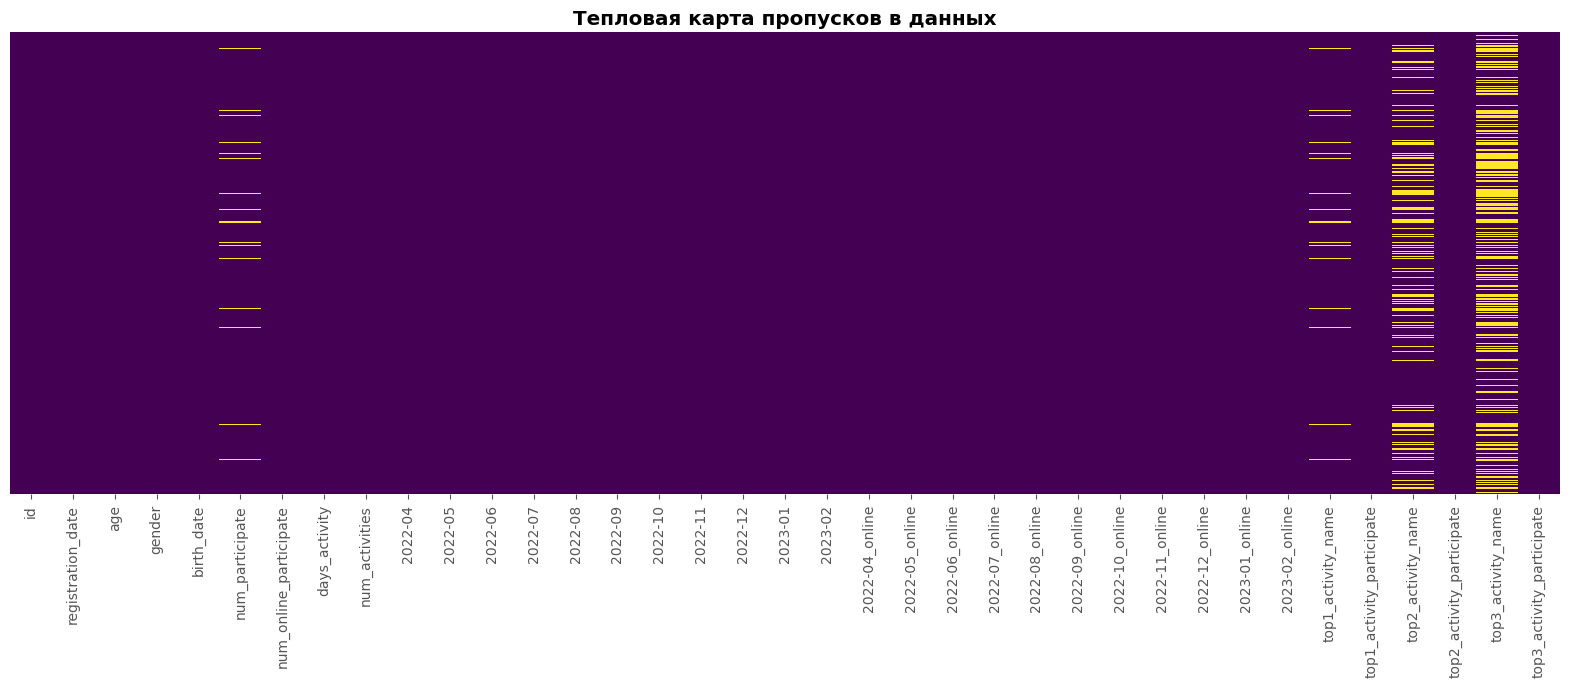

In [8]:
plt.subplots(figsize=(20, 6))

sns.heatmap(df.isna(), yticklabels=False, cmap='viridis', cbar=False).set_title('Тепловая карта пропусков в данных', weight="bold");

Для нас критичны пропуски только в переменной `num_participate`, поэтому избавимся только от них

In [9]:
df.dropna(subset='num_participate', inplace=True)

#### Приводим переменные к соответствующим типам данных

Оставляем только участников, которые зарегистрировались до 2022-04

In [10]:
df['registration_date'] = pd.to_datetime(df['registration_date'])
df = df[df.registration_date <= datetime(2022, 4, 1)]

In [11]:
df['birth_date'] = pd.to_datetime(df['birth_date'])
df['num_participate'] = df['num_participate'].astype('int64')

#### Работаем над устройством переменных

Также, можно заметить, что переменная `num_participate` содержит значения суммарные для оффлайн и онлайн форматов. Было бы удобнее, если бы у нас в датафреме имелась переменная, которая хранит значения посещенных оффлайн мероприятий. При этом, **чтобы избежать мультиколлинеарности**, избавимся от переменной с общим числом посещенных мероприятий, то есть `num_participate`.

Таким образом, в нашем датафрейме должно храниться 2 переменные характеризующие количество посещенных онлайн и оффлайн мероприятий - `num_online_participate` и `num_offline_participate` соответственно.

In [12]:
df['num_offline_participate'] = df['num_participate'] - df['num_online_participate']
df.drop(columns='num_participate', inplace=True)

То же касается и столбцов 2022-04, ... 2023-02.

In [13]:
df.loc[:, '2022-04':'2023-02'] -= df.loc[:, '2022-04_online':'2023-02_online'].values

Также, стоит упомянуть, что переменная `birth_date` является более расширенной версией переменной `age`, однако не думаю, что в нашем анализе это может пригодиться, поэтому мы спокойно можем избавиться от данного столбца

In [14]:
df.drop(columns='birth_date', inplace=True)

Создаем переменную, в которой будет храниться количество дней участия в программе, с момента регистрации и до сбора данных.

In [15]:
df['days_in'] = (df.registration_date - datetime(2023, 3, 1)).abs().dt.days

#### Оформляем датафрейм

In [16]:
col_order = ['id', 'age', 'gender', 'registration_date', 'days_in',
             'days_activity', 'num_activities',
             'num_offline_participate', 'num_online_participate',
             'top1_activity_name', 'top1_activity_participate',
             'top2_activity_name', 'top2_activity_participate',
             'top3_activity_name', 'top3_activity_participate',
             '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09', 
             '2022-10', '2022-11', '2022-12', '2023-01', '2023-02',
             '2022-04_online', '2022-05_online', '2022-06_online', '2022-07_online',
             '2022-08_online', '2022-09_online', '2022-10_online', '2022-11_online',
             '2022-12_online', '2023-01_online', '2023-02_online']

df = df[col_order]

In [17]:
df.index = range(len(df.index))

In [18]:
df.head(5)

,id,age,gender,registration_date,days_in,days_activity,num_activities,num_offline_participate,num_online_participate,top1_activity_name,top1_activity_participate,top2_activity_name,top2_activity_participate,top3_activity_name,top3_activity_participate,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,2022-04_online,2022-05_online,2022-06_online,2022-07_online,2022-08_online,2022-09_online,2022-10_online,2022-11_online,2022-12_online,2023-01_online,2023-02_online
0,101391104,64,female,2019-02-26,1464,124,5,75,59,ONLINE English language,51,General physical training,30,"Fitness, exercise equipment",25,10,6,6,6,16,5,6,4,4,6,6,14,6,3,10,6,6,3,3,3,5,0
1,101351338,67,female,2018-03-19,1808,24,4,14,13,ONLINE Drawing,13,Gymnastics,10,Dancing,2,0,0,0,0,0,0,0,4,10,0,0,0,0,0,0,0,7,4,2,0,0,0
2,101354578,84,female,2018-03-22,1805,106,9,40,94,ONLINE Gymnastics,39,ONLINE Live well,29,Information technology,16,5,4,0,0,0,2,2,7,9,5,6,15,19,1,0,0,0,2,12,12,13,20
3,101411997,72,female,2019-12-17,1170,63,2,0,76,ONLINE Drawing,72,ONLINE Educational workshop,4,NaN,0,0,0,0,0,0,0,0,0,0,0,0,4,1,13,9,11,14,11,5,3,0,5
4,101387414,86,female,2019-01-23,1498,116,5,0,155,ONLINE Gymnastics,77,ONLINE Beauty and style,46,ONLINE Educational workshop,21,0,0,0,0,0,0,0,0,0,0,0,9,7,9,7,7,22,24,29,16,12,13


### **Генерируем метрики**

На данном шаге нам необходимо построить метрику, которая будет информативной и поможет в последующем анализе. В данном случае, нас интересует посещаемость, поэтому давайте построим метрику вокруг нее.

Мы имеем количество дней, прошедшее с 2022-04-01 по 2023-03-01 для каждого из участников программы, а также имеем количество посещенных мероприятий, проводимых в онлайн и оффалйн форматах - `num_online_participate` и `num_offline_participate` соответственно. Тогда мы можем построить метрику, которая будет говорить о том, какое количество занятий в среднем посещает за день клиент.

Считаться эта метрика будет следующим образом:
$$
\cfrac{\text{num\_online\_participate} + \text{num\_offline\_participate}}
{\text{days\_in}}
$$

Также, мы можем рассчитать данную метрику по каждому из форматов для того, чтобы исследовать онлайн и оффлайн форматы отдельно. Однако, в таком случае важно учесть, что сумма `num_online_participate` и `num_offline_participate` всегда больше нуля, однако каждая переменная поотдельности может представлять собой нулевое значение. Это может привести к выбросам и в таком случае есть решение - рассмотреть отдельно две группы из общей выборки: тех, кто предпочитает исключительно онлайн, и тех, кто предпочитает только оффлайн.

Таким образом, первый способ является несостоятельным, прибегнем ко второму.

In [19]:
df['attendance'] = (df.num_offline_participate + df.num_online_participate) / df.days_in
df['online_attendance'] = df.num_online_participate / df.days_in
df['offline_attendance'] = df.num_offline_participate / df.days_in

Давайте посмотрим на то, как распределена данная величина

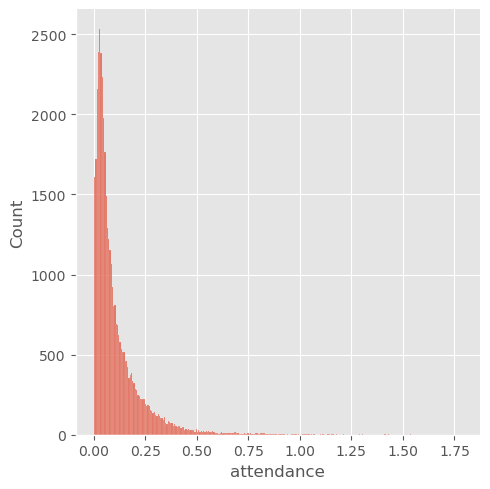

In [20]:
sns.displot(df.attendance);

Судя по всему, данная величина возможно имеет логнормальное распределение с относительно длиннаым хвостом, то есть достаточно большим количеством выбросов по правую сторону, которые необходимо удалить

### **Классификация выборки на группы**

#### Изучаем распределенрие посещений

Чтобы провести более точный анализ, корректнее будет проанализировать посещаемость по онлайн и оффлайн форматам отдельно, поэтому нам необходимо разбить нашу основную выборку на несколько групп.

Для начала, давайте посмотрим на распределение количества участий пенсионеров в мероприятиях.

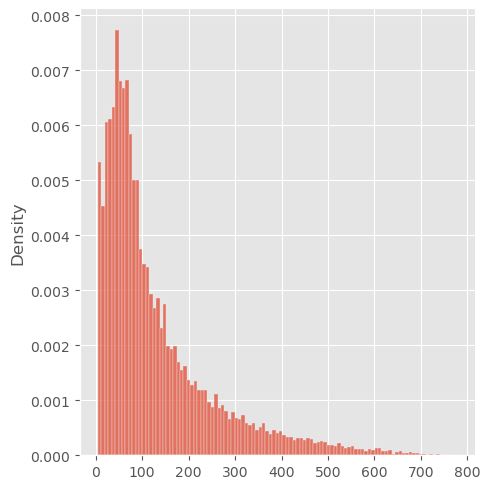

In [21]:
sns.displot(df.num_online_participate + df.num_offline_participate, stat='density');

Можно заметить аномально высокую частоту распределения при минимальных значениях. Давайте присмотримся к данной ситуации чуть пристальнее.

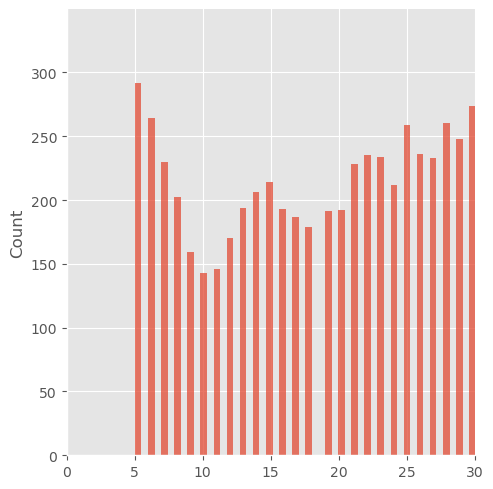

In [22]:
sns.displot(df.num_online_participate + df.num_offline_participate, bins=1600).ax.set_xlim(0, 30);

Действительно, можем увидеть, что до значения 10 (включительно) имеется аномально высокая плотность распределения. С учетом того, что мы избавились в выборке от тех, участников, которые зарегистрировались ранее 2022-04, можно заключить, что данная группа неактивна. То есть когда-то эти люди начали посещать мероприятия, но какая-либо причина их остановила.

#### Создаем целевую выборку

Давайте избавимся от этой группы и создадим основную выборку.

In [23]:
main_group = df[df.num_online_participate + df.num_offline_participate > 10].copy()

Забираем только нужные данные в выборку

In [24]:
col_order = [
    'age', 'gender', 'days_in', 'days_activity', 'num_activities',
    'num_offline_participate', 'num_online_participate',
    'attendance', 'offline_attendance', 'online_attendance',
    'top1_activity_name', 'top1_activity_participate',
    'top2_activity_name', 'top2_activity_participate',
    'top3_activity_name', 'top3_activity_participate'
]
main_group = main_group[col_order]

#### Делим выборку на группы

Теперь давайте приступик к группировке. Можно выделить следующие группы:
* предпочитают только онлайн - онлайн 95-100% - `only_online`
* предпочитают только оффлайн - оффлайн 95-100% - `only_offline`
* интересуют оба формата в равной степени - онлайн 40-60%, оффлайн 60-40% - `both_formats`
* в большей мере предпочитают онлайн - онлайн 60-95% - `more_online`
* в большей мере предпочитают оффлайн - оффлайн 60-95% - `more_offline`

In [25]:
online_percentage = main_group.num_online_participate / (main_group.num_online_participate + main_group.num_offline_participate)

group_name = np.where(online_percentage <= 0.05,
                      'only_offline',
                      np.where(online_percentage >= 0.95,
                               'only_online',
                               np.where(online_percentage > 0.6,
                                        'more_online',
                                        np.where(online_percentage < 0.4,
                                                 'more_offline',
                                                 'both_formats'
                                                 )
                                         )
                                 )
                     )

main_group['group_name'] = group_name

#### Визуализация распределений по группам

Давайте посмотрим на график распределения основаной метрики `attendance` по группам:

In [26]:
def show_groups_metric(
        data: pd.DataFrame, *, group_col: str, group_names: list[str],
        metric_name: str, colors: list[tuple[float, float, float]],
        bins: int = 100, kde: bool = False, density: bool = False
) -> plt.Axes:
    plt.figure(figsize=(20, 7))
    ax = plt.subplot()

    # Ищем размер одного бина
    bin_size = max(
        data[data[group_col] == name][metric_name].max() - data[data[group_col] == name][metric_name].min()
        for name in group_names
    ) / bins

    for name, color in zip(group_names, colors):
        sample = data[data[group_col] == name][metric_name]
        
        # Ищем кол-во бинов одного размера
        curr_bins = round((sample.max() - sample.min()) / bin_size)

        ax.hist(
            x=sample, bins=curr_bins, alpha=.5, color=color, edgecolor='white',
            label=name, density=density
        )

        if kde:
            # Считаем сглаженные x и y
            kde_func = stats.gaussian_kde(sample)
            xs = np.linspace(min(sample), max(sample), curr_bins * 2)
            ys = kde_func(xs) * (sample.size / bins, 1)[density]
            ax.plot(xs, ys, color=color, linewidth=3)


    if density:
        # Заменяем частоту на правильную
        new_ticks = list(map(lambda x: float(x.get_text()) / bins, plt.yticks()[1]))
        plt.yticks(plt.yticks()[0], new_ticks)
    
    plt.ylabel('Density')
    plt.xlabel(metric_name)

    plt.legend()
    plt.title(f'Распределение метрики {metric_name} по группам')

    return ax

In [27]:
colors = (
    sns.color_palette("tab10")[0], sns.color_palette("tab10")[2],
    sns.color_palette("tab10")[3], sns.color_palette("tab10")[1],
    sns.color_palette("tab10")[4]
)

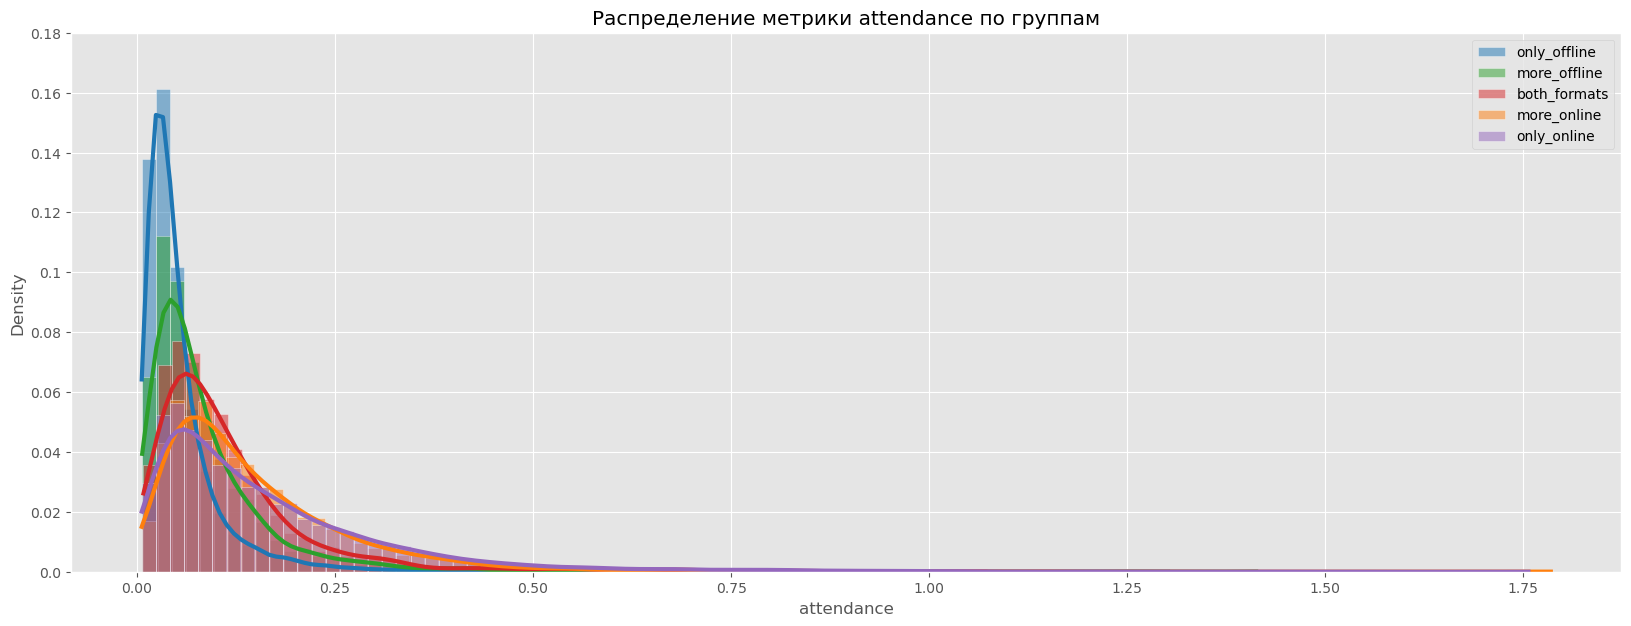

In [28]:
groups = ('only_offline', 'more_offline', 'both_formats', 'more_online', 'only_online')

show_groups_metric(
    main_group, group_col='group_name', group_names=groups,
    metric_name='attendance', colors=colors[:len(groups)],
    kde=True, density=True
);

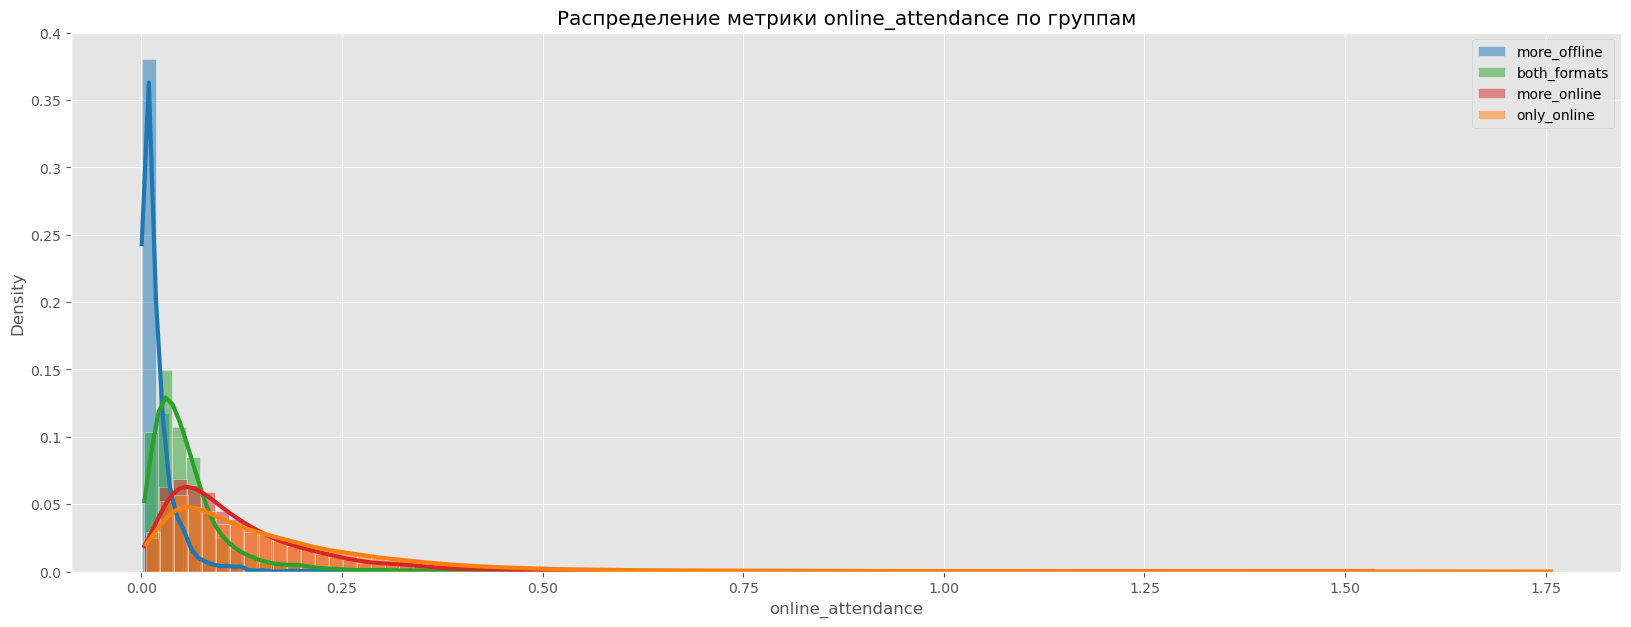

In [29]:
groups = ('more_offline', 'both_formats', 'more_online', 'only_online')

show_groups_metric(
    main_group, group_col='group_name', group_names=groups,
    metric_name='online_attendance', colors=colors[:len(groups)],
    kde=True, density=True
);

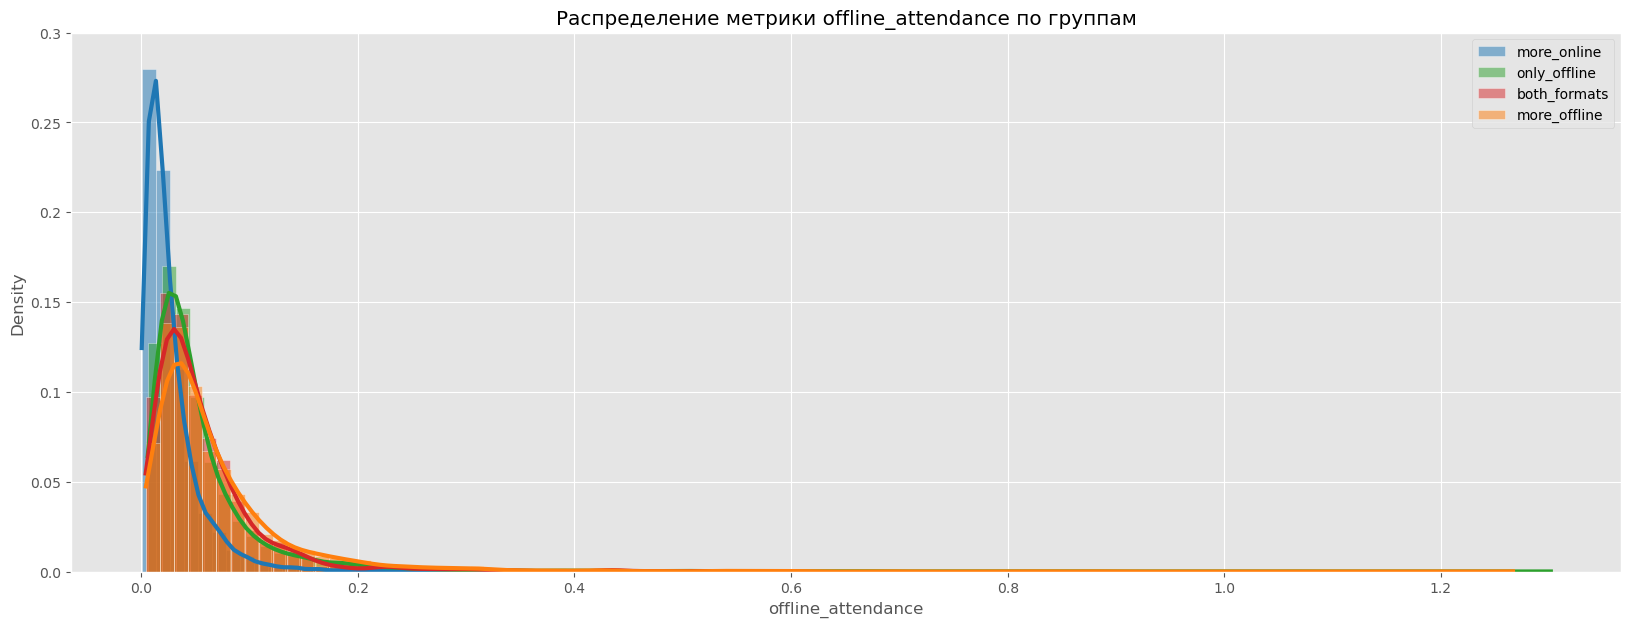

In [30]:
groups = ('more_online', 'only_offline', 'both_formats', 'more_offline')

show_groups_metric(
    main_group, group_col='group_name', group_names=groups,
    metric_name='offline_attendance', colors=colors[:len(groups)],
    kde=True, density=True
);

**Вывод**: видим, что ассимитричность распределений сохранилась, однако заметно, что сами распределения отличаются на неизвестный параметр $\theta$. Также, в большинстве групп присутствуют сильные выбросы, от которых мы избавимся дальше

### **Избавляемся от выбросов**

Итак, давайте избавимся от аномалий и выбросов в данных. Делать мы это будем с помощью метода скорректированных интервалов для смещенных распределений и обычным методом интервалов для нормально распределенных статистик.

Определим функцию для избавления от выбросов в выборках.

In [31]:
def drop_outliers(sample: pd.DataFrame) -> pd.DataFrame:
    sample.reset_index(inplace=True)
    sample.drop('index', axis=1, inplace=True)

    metrics = {
        'num_activities': 'median',
        'age': 'mean',
        'attendance': 'median',
        'online_attendance': 'median',
        'offline_attendance': 'median'
    }

    if sample.group_name[0] == 'only_offline':
        del metrics['online_attendance']
    elif sample.group_name[0] == 'only_online':
        del metrics['offline_attendance']
    
    condition = pd.Series([True] * sample.shape[0]) # Условный вектор

    for m, stat in metrics.items():
        ser = sample[m]

        # Ищем межквартильный размах
        l, r = np.quantile(ser, .25), np.quantile(ser, .75)
        l_iqr_coef = r_iqr_coef = 1.5 * (r - l)

        if stat == 'median':
            # Ищем коэффициент медианной асимметрии
            mc = medcouple(ser)

            l_coef, r_coef = (-4, 3) if mc >= 0 else (-3, 4)

            # Корректируем интервал
            l_iqr_coef *= np.exp(l_coef * mc)
            r_iqr_coef *= np.exp(r_coef * mc)
        
        # Ищем левую и правую границы интервала
        left_border = l - l_iqr_coef
        right_border = r + r_iqr_coef

        # Пересекаем текущий условный вектор по метрике с предыдущим
        condition &= ((ser > left_border) & (ser < right_border))
    
    new_sample = sample[condition].reset_index().drop('index', axis=1)
    
    return new_sample

Размеры групп ДО чистки:

In [32]:
main_group.groupby('group_name').size()

group_name
both_formats     1629
more_offline     2724
more_online      6255
only_offline    16209
only_online     12920
dtype: int64

Посмотрим на результаты чистки на примере группы `only_offline`. Распределение ДО чистки:

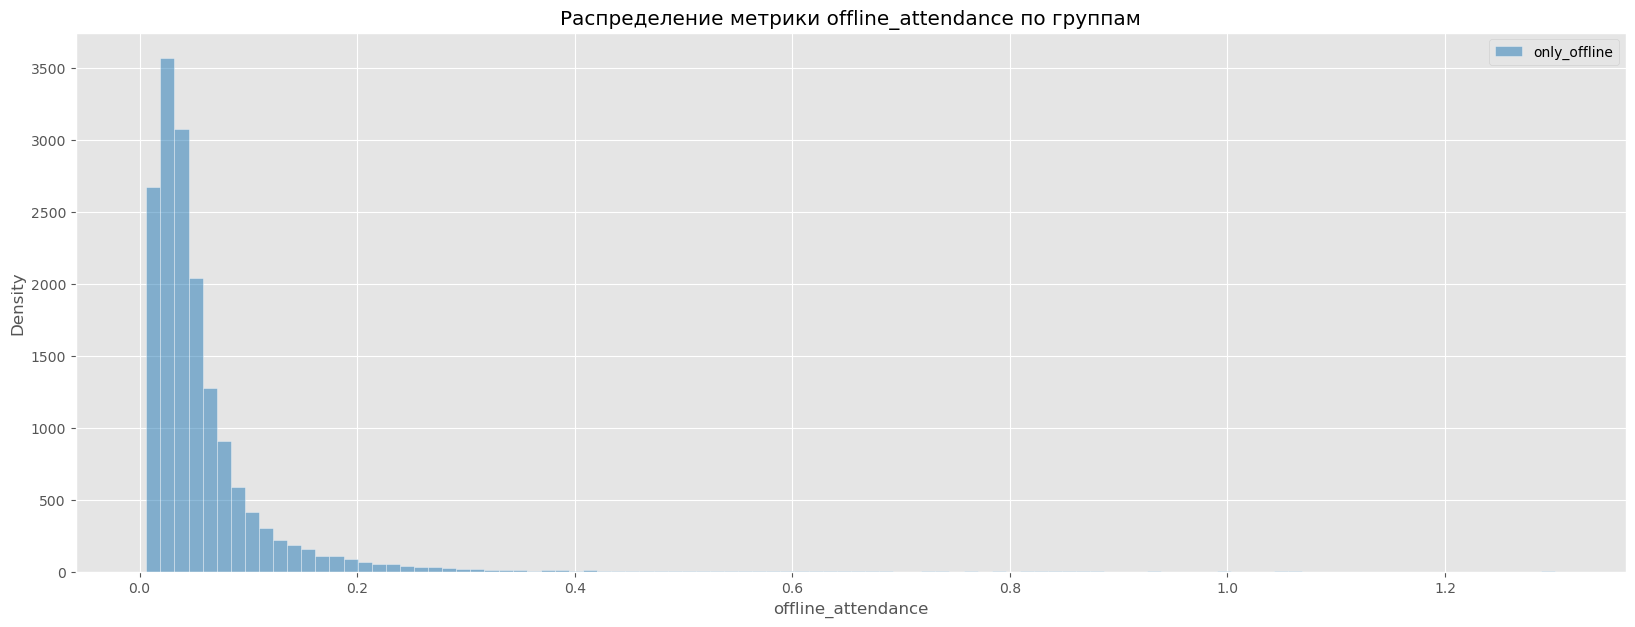

In [33]:
show_groups_metric(
    main_group, group_col='group_name', group_names=('only_offline', ),
    metric_name='offline_attendance', colors=(colors[0], )
);

In [34]:
main_group = pd.concat([drop_outliers(gr[1]) for gr in main_group.groupby('group_name')])

Размеры групп ПОСЛЕ чистки:

In [35]:
main_group.groupby('group_name').size()

group_name
both_formats     1497
more_offline     2521
more_online      5919
only_offline    15625
only_online     12640
dtype: int64

Распределение группы `only_offline` ПОСЛЕ чистки:

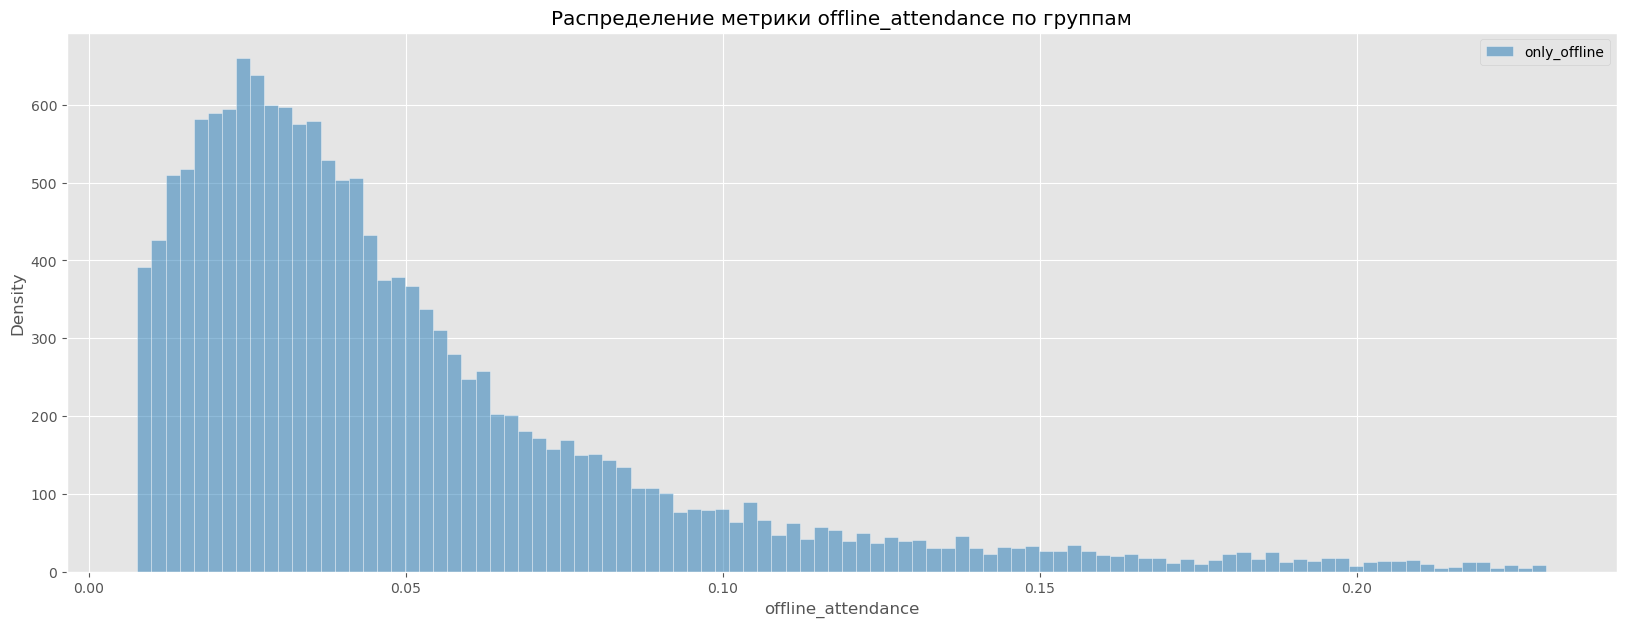

In [36]:
show_groups_metric(
    main_group, group_col='group_name', group_names=('only_offline', ),
    metric_name='offline_attendance', colors=(colors[0], )
);

**Вывод**: хвост, который тянулся вплоть до значения 1.4 был отрезан примерно до значения 0.25, что говорит о том, что мы действительно избавились от выбросов

### **Изучаем доли мужчин и женщин в выборке**

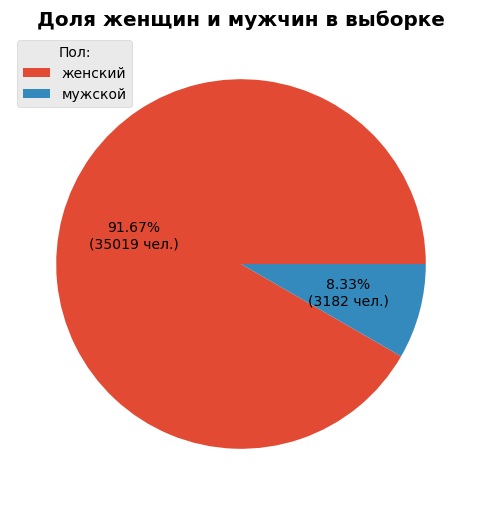

In [37]:
gender_dist = main_group.groupby('gender').size()

fmt = lambda x: f"{x:.2f}%\n({(int(x / 100 * gender_dist.sum()))} чел.)"

fig, ax = plt.subplots(figsize=(6, 6))

*_, autotexts = ax.pie(gender_dist, autopct=fmt)

plt.setp(autotexts, size=10)
ax.legend(['женский', 'мужской'], title="Пол:", loc="upper left", fontsize=10)
ax.set_title('Доля женщин и мужчин в выборке', weight="bold");

### **Изучаем пол и возраст**

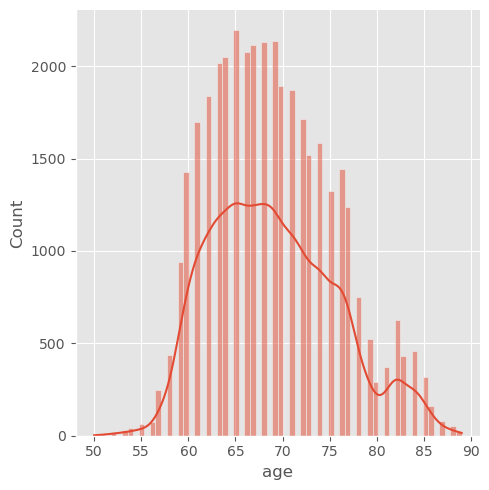

In [38]:
sns.displot(x=main_group.age, kde=True);

**Вывод**: на получившемся графике можно наблюдать слабовыраженную бимодальность. Мое предположение заключается в том, что она обосновывается падением уровня рождаемости во время Великой Отечественной войны. А асимметрия с крутым подъемом от 55 до 65 обосновывается притоком пенсионеров по достижению пенсионного возраста, после которого идет асимметричный спад по причине смертности.

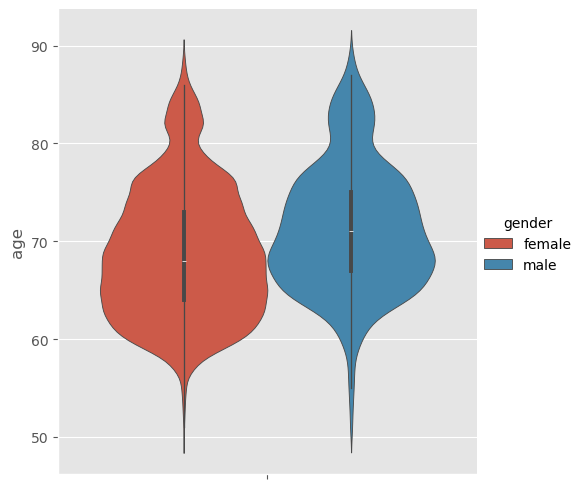

In [39]:
sns.catplot(y=main_group.age, hue=main_group.gender, kind='violin');

**Вывод**: медианный возраст для мужчин несколько больше чем для женщин женщин, но сами виолончели похожи по форме.

### **Посещаемость по месяцам**

Давайте проанализируем посещаемость по месяцам и выявим тренды.

In [40]:
offline_year = df.loc[:, '2022-04':'2023-02'].mean()
online_year = df.loc[:, '2022-04_online':'2023-02_online'].mean()
online_year.index = online_year.index.str.removesuffix('_online')
online_year.name = 'онлайн'
offline_year.name = 'оффлайн'

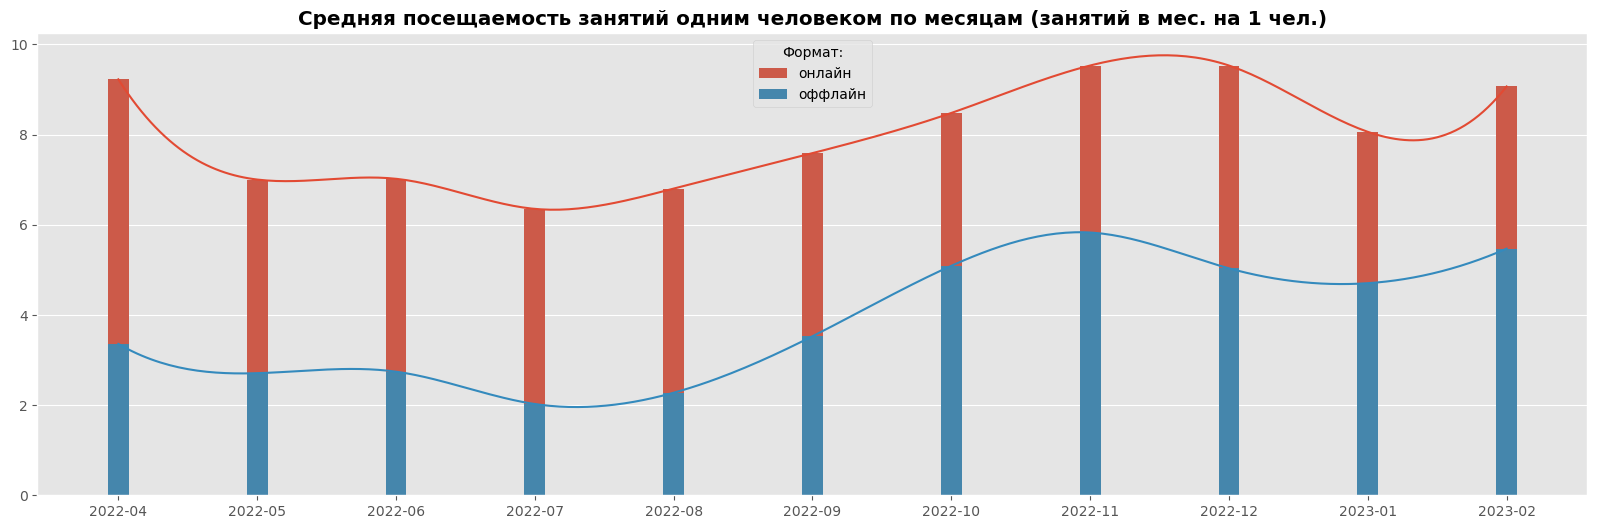

In [41]:
_, ax = plt.subplots(figsize=(20, 6))

idx = range(online_year.size)
xnew = np.linspace(min(idx), max(idx), 300)

for i in (online_year, offline_year):
    spl = make_interp_spline(idx, i.values, k=3)
    smooth = spl(xnew)

    sns.barplot(i, width=.15, ax=ax, label=i.name)
    ax.plot(xnew, smooth)

plt.title('Средняя посещаемость занятий одним человеком по месяцам (занятий в мес. на 1 чел.)', weight="bold")
plt.legend(title='Формат:')
plt.ylabel(None);

**Вывод**: пик посещаемости приходится на ноябрь-декабрь, однако в январе активность резко спадает, что может быть связано с праздниками и желанием провести больше времени с близкими. В феврале средняя посещаемость резко возрастает, затем к маю снова стремительно снижается, что может обосновываться оттоком пенсионеров в санатории и на курорты.

### **Точечный график нескольких переменных по половому признаку**

Давайте построим график, на котором будут отражаться такие переменные как:
* `days_in` - кол-во дней, с момента регистрации;
* `days_activity` - кол-во дней, в которые клиент учавтствовал в каком-либо мероприятии;
* `age` - возраст клиента.
Для большей информативности разобъем выборку на мужчин и женщин.

In [42]:
fig = px.scatter_3d(
    main_group, x='days_in', y='days_activity', z='age', symbol='gender',
    color='gender', opacity=0.7, height=768, width=1024
)
fig.update_traces(marker_size=3)
fig.show()

**Вывод**: можно заметить, что некоторый период во время пандемии регистраций на программу не было вовсе, а после возобновления своей деятельности приток клиентов возобновился, но в меньшем объеме. Также, стоит отметить, что явных взаимосвязей на графике не прослеживается, за исключением слабого роста количества активных дней по мере количества прошедших дней после регистрации.

### **Обзор ключевых метрик**

Стоит отметить, что ключевыми метриками в нашем анализе являются:
* `attendance` - кол-во посещенных занятий за день;
* `num_activities` - количество уникальных активностей;
* `age` - возраст.

Первые две метрики имеют явно выраженное скошенное распределение, поэтому для их подсчета мы будем использовать медиану. Возраст же имеет распределение сильно похожее на нормальное, поэтому для его подсчета мы будем использовать среднее значение.

Далее сгруппируем выборку по уже готовым названиям групп, а далее подсчитаем по группам необходимые статистики

In [43]:
groups = main_group.groupby('group_name')

median_attendance = groups.attendance.median()
median_activities = groups.num_activities.median().astype('int8')
mean_age = groups.age.mean().round(1)

Теперь сформируем датафрейм и оформим его

In [44]:
metrics = pd.concat([median_attendance, median_activities, mean_age], axis=1).reset_index()
metrics.columns = ['group_name', 'median_attendance', 'median_activities', 'mean_age']

In [45]:
metrics.sort_values('median_attendance', ignore_index=True, ascending=False)

,group_name,median_attendance,median_activities,mean_age
0,only_online,0.1199,4,67.9000
1,more_online,0.1131,6,68.0000
2,both_formats,0.0832,6,68.0000
3,more_offline,0.0610,5,68.1000
4,only_offline,0.0388,2,70.5000


**Вывод**: сразу бросается в глаза, что медианные посещаемости распределились по строгому убыванию предпочитаемости онлайн-формата. То же касается и среднего возраста, но гораздо менее явно . Касательно медианного количества уникальных активностей можно сказать, что в группах, которые совмещают форматы медиана больше, нежели в тех, что предпочитают сугубо один формат проведения занятий. Также, примечательно, что разница в медианной посещаемости групп `more_online` и `only_online`. И последнее, интересным является то, что для всех групп средний возраст почти не отличается кроме группы `only_offline`.

### **Диаграмма долей групп с разбивкой по предпочитаемому формату**

Давайте построим диаграмму, чтобы лучше понять как поделены данные группы в процентном соотношении. А также поделим группы по половому признаку.  
Для начала подготавливаем данные:

In [46]:
grouped_data = main_group.groupby('group_name').size()

outter_data = (
    grouped_data['more_offline'] + grouped_data['only_offline'],
    grouped_data['both_formats'],
    grouped_data['more_online'] + grouped_data['only_online'],
)
inner_data = (
    grouped_data['only_offline'], grouped_data['more_offline'],
    grouped_data['both_formats'], grouped_data['more_online'],
    grouped_data['only_online'],
)

Выбираем цвета, создаем функцию для форматирования надписей и устанавливаем параметр размера

In [47]:
outter_colors = [sns.color_palette("tab10")[0], sns.color_palette("tab10")[4],
                 sns.color_palette("tab10")[3]]
inner_colors = [sns.color_palette('Paired')[1], sns.color_palette('Paired')[0],
                sns.color_palette('Paired')[8], sns.color_palette('Paired')[4],
                sns.color_palette('Paired')[5]]

labels = ('only_offline', 'more_offline','both_formats', 'more_online', 'only_online')

fmt = lambda x: f"{x:.2f}%"
size = 0.3

Строим график

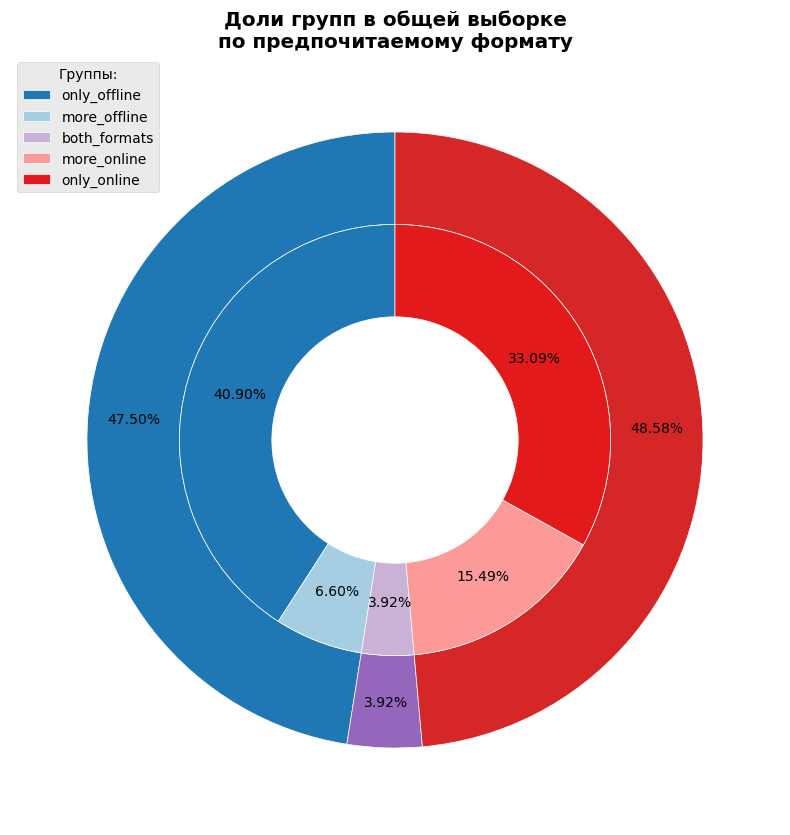

In [48]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.pie(
    outter_data, radius=1, autopct=fmt, pctdistance=.85, startangle=90,
    colors=outter_colors, wedgeprops=dict(width=size, edgecolor='w')
)
handles, *_ = ax.pie(
    inner_data, radius=1 - size, autopct=fmt, pctdistance=.75, startangle=90,
    colors=inner_colors, wedgeprops=dict(width=size, edgecolor='w')
)

plt.title('Доли групп в общей выборке\nпо предпочитаемому формату', weight="bold")
plt.legend(handles=handles, labels=labels, title='Группы:', loc='upper left');

**Вывод**: сумма долей групп `more_offline` и `only_offline` эквивалентна сумме долей `more_online` и `only_online`, однако в разных пропорциях. То есть группа `only_offline` гораздо больше, чем `more_offline`, в то время как `more_online` и `only_online` приблизительно равны. Это говорит о большом потенциале перехода более консервативных пользователей из группы `only_offline` в `both_fotmats`, `more_online` или `only_online`. Также малая доля группы `both_formats` на ряду с малой долей `more_offline` может говорить о том, что переход из группы `only_offline` идет преимущественно в `more_online` и `only_online` и на то может быть несколько причин:
1. Пенсионеры не понимают преимущества онлайн-формата, а когда впервые контактируют с ним, онлайн-формат становится их предпочтительным. Это может происходить по причине того, что организация недостаточно хорошо освещает онлайн-формат среди группы, предпочитающей оффлайн.
2. Уровень проведения онлайн и оффлайн мероприятий сильно различается в сторону преимущества онлайн.
3. Отдельная группа пользователей, которая ставит целью именно физическую активность

### **Анализ зависимостей**

Теперь давайте приступим к анализу зависимостей. Начать стоит с того, какие переменные мы возьмем для анализа:
* `attendance` - ключевая переменная, в которой выражено среднее кол-во занятий посещенных за день;
* `offline_sessions` (`num_offline_participate`) - кол-во посещенных оффлайн-занятий;
* `online_sessions` (`num_online_participate`) - кол-во посещенных онлайн-занятий;
* `num_activities` - кол-во уникальных активностей;
* `age` - возраст клиента.

Потом мы выбераем исключительно те переменные, по которым хотим посчитать корреляцию и сразу же реализуем корреляционную матрицу Спирмена.

In [49]:
vars = main_group[['attendance', 'num_offline_participate', 'num_online_participate', 'num_activities', 'age']]

vars.columns = ['attendance', 'offline_sessions', 'online_sessions', 'num_activities', 'age']

corrs = vars.corr('spearman')

Теперь, когда все готово, построим тепловую карту:

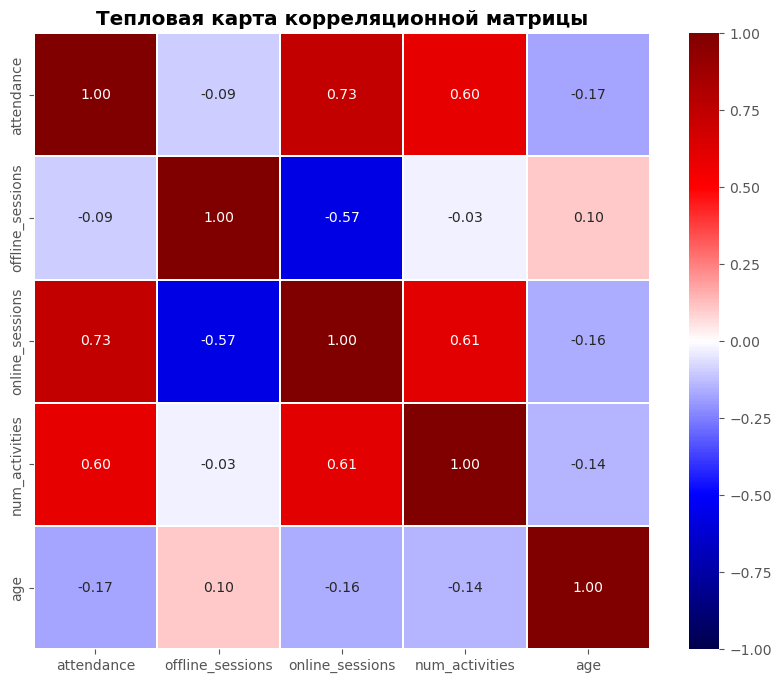

In [50]:
plt.subplots(figsize=(10, 8))

sns.heatmap(
    data=corrs, vmax=1, vmin=-1, annot=True, fmt='.2f',
    linewidths=.1, cmap='seismic', square=True
).set_title('Тепловая карта корреляционной матрицы', weight="bold");

Видим на карте достаточно сильную коррелированность некоторых переменных. Имея ввиду, что размер нашей выборки составляет почти 40_000 наблюдений, давайте посмотрим на статистическую значимость самой меньшей по модулю корреляции - между `num_activities` и `offline_sessions`:

In [51]:
corr(vars.num_activities, vars.offline_sessions, method='spearman')

,n,r,CI95%,p-val,power
spearman,38202,-0.0303,"[-0.04, -0.02]",0.0000,1.0000


**Вывод**: здесь стоит обратить внимание на p-value, которое настолько ниже нуля, что приравнивается к нему, и мощность теста составляет 99.99%. Все это в совокупности говорит нам о том, что корреляция превышающая 0.03 по модулю (включительно) является статистически значимой и мы должны учитывать ее.

----
Таким образом, давайте рассудим то, что мы наблюдаем:
1. Умеренная отрицательная коррелированность количества посещенных онлайн и оффлайн занятий говорит о том, что **пенсионеры склонны отдавать предпочтение только одному из форматов**;
2. Возраст относительно слабо, но коррелирует со всеми остальными параметрами и при общем обзоре становится понятно, что **при увеличении возраста, активность клиентов несколько убывает**, но не сильно, так как сам коэффициент корреляции достаточно низок;
3. **Количество посещенных онлайн-занятий очень положительно сказывается на посещаемости, чего нельзя сказать про оффлайн-мероприятия**, которые имеют хоть и небольшую, но отрицательную корреляции с `attendance`, что можно интерпретировать как увеличение количества дней до следующего посещения;
4. **Увеличение посещенных онлайн-занятий положительно сказывается на количесвто уникальных активностей**, чего так же нельзя сказать про оффлайн-мероприятия, которые оказывают хоть и небольшой, но негативный эффект.
5. Видим, что **количество уникальных активностей положительно сказывается на посещаемость**, к чему стоит относиться более аккуратно, так как этот эффект может быть обоснован высокой корреляцией с количеством посещенных онлайн-мероприятий, который, в свою очередь, так же имеет положительную корреляцию с `attendance`.
----
Предположения, основанные на наблюдениях:
* удобность онлайн-формата занятий обеспечивает больше свободного времени и сил, так как они не тратятся на перемещение, что позволяет участвовать в дополнительных активностях;
* онлайн-формат стимулирует участвовать в большем числе активностей, что увеличивает посещаемость;
* программа "Московское долголетие" не способствует обучению и адаптации пенсионеров к современным технологиям, что приводит к упущеннию потенциальной посещаемости онлайн-занятий пенсионерами, которые предпочитают оффлайн-формат.

### **Проверка гипотез**

#### Пререквизиты

Прежде всего необходимо определиться с тем, какую меру центральной тенденции мы возьмем для проведения статистических тестов. Среднее значение - крайне неустойчиво к выбросам и асимметрии распределения, соответственно приходим к выводу о том, что **в качестве статистики для сравнения необходимо взять медиану**.

Далее, нам необходимо понять каким именно образом проверять гипотезы.

Мы можем применить логарифмирование или преобразование Бокса-Кокса, чтобы нормализовать матрики и применить к ним параметрические тесты, однако параметрические тесты не предоставляют возможности для сравнения медиан.

Касательно непараметрических методов, они предоставляют возможность сравениния медиан, однако предполагают либо симметричность распределения, либо связанность выборок и имеют низкую мощность.

Таким образом, для проверки гипотез **мы прибегнем к методу бутстрап**:
* мы создадим 10_000 бутстрап-выборок с повторениями;
* применим центрирование Холла для разности медиан;
* посчитаем квантили на 1% уровне значимости;
* посмотрим попадает ли ноль между квантилей.

Гипотезы:
1. Небольшая доля онлайн-мероприятий в общем числе посещенных занятий способствует увеличению посещаемости оффлайн-занятий:
$$\begin{aligned}
&H_0: \ Med(X_{only\_offline}^{offline\_attendance}) = Med(X_{more\_offline}^{offline\_attendance}) \ -\ \text{медианы групп only\_offline и more\_offline по метрике \underline{offline\_attendance} равны} \\
&H_1: \ Med(X_{only\_offline}^{offline\_attendance}) < Med(X_{more\_offline}^{offline\_attendance})  \ -\ \text{медиана в группе only\_offline меньше, чем в группе more\_offline}
\end{aligned}$$
2. Даже та группа, готорая в большей мере предпочитает онлайн-формат, посещает оффлайн-занятия чаще, чем респонденты, предпочитающие исключительно оффлайн-формат:
$$\begin{aligned}
&H_0: \ Med(X_{only\_offline}^{offline\_attendance}) = Med(X_{more\_online}^{offline\_attendance}) \ -\ \text{медианы групп only\_offline и more\_online по метрике \underline{offline\_attendance} равны} \\
&H_1: \ Med(X_{only\_offline}^{offline\_attendance}) < Med(X_{more\_online}^{offline\_attendance})  \ -\ \text{медиана в группе only\_offline меньше, чем в группе more\_online}
\end{aligned}$$
3. Даже в качестве неосновного предпочитаемого формата, оффлайн-формат негативно сказывется на посещаемости онлайн-занятий:
$$\begin{aligned}
&H_0: \ Med(X_{only\_online}^{online\_attendance}) \le Med(X_{more\_online}^{online\_attendance}) \ -\ \text{медианы групп only\_online и more\_online по метрике \underline{online\_attendance} равны или медиана only\_online меньше} \\
&H_1: \ Med(X_{only\_online}^{online\_attendance}) > Med(X_{more\_online}^{online\_attendance})  \ -\ \text{медиана в группе only\_online больше, чем в группе more\_online}
\end{aligned}$$
4. Онлайн-формат способствует большей совокупной посещаемости, нежели оффлайн-формат:
$$\begin{aligned}
&H_0: \ Med(X_{only\_online}^{attendance}) = Med(X_{only\_offline}^{attendance}) \ -\ \text{медианы групп only\_online и only\_offline по метрике \underline{attendance} равны} \\
&H_1: \ Med(X_{only\_online}^{attendance}) > Med(X_{only\_offline}^{attendance})  \ -\ \text{медиана в группе only\_online больше, чем в группе only\_offline}
\end{aligned}$$
5. Существует "возрастной" барьер для входа в онлайн-формат:
$$\begin{aligned}
&H_0: \ \mu_{only\_online}^{age} = \mu_{only\_offline}^{age} \ -\ \text{средние значения групп only\_online и only\_offline по метрике \underline{age} равны} \\
&H_1: \ \mu_{only\_online}^{age} < \mu_{only\_offline}^{age}  \ -\ \text{среднее в группе only\_online меньше, чем в группе only\_offline}
\end{aligned}$$

#### Бутстрап

Определим основную функцию для проведения бутстрап-теста разности медиан и дополнительные для генерации бутстрап-выборки и построения графика распределения разности медиан и доверительного интервала.

In [52]:
def _get_bootstrap_sample(data: pd.Series | np.ndarray, B: int) -> np.ndarray:
    n = data.size
    sample = np.random.choice(data, size=(n, B), replace=True)

    return sample


def _show_confidence_interval(
        x, borders, mean_med, *, figsize=(20, 7), linewidth=3,
        color=sns.color_palette("tab10")[0]
) -> None:
    plt.figure(figsize=figsize)
    ax = plt.subplot()

    # Строим распределение медианы разности
    *_, h = ax.hist(x, edgecolor='white', color=color)

    # Отмечаем среднее медиан
    txt_x = mean_med - (plt.xlim()[1] - plt.xlim()[0]) * 0.02
    txt_y = plt.ylim()[1] * 0.5
    med = ax.axvline(mean_med, linestyle=':', color='black', linewidth=linewidth)
    ax.text(
        txt_x, txt_y, s=f'{mean_med:.4f}', rotation='vertical', fontsize=14, 
        fontweight='semibold'
    )

    # Строим границы доверительного интервала
    for b in borders:
        txt_x = b - (plt.xlim()[1] - plt.xlim()[0]) * 0.02
        txt_y = plt.ylim()[1] * 0.7

        line = ax.axvline(b, linestyle='-.', color=color, linewidth=linewidth)
        ax.text(
            txt_x, txt_y, s=f'{b:.4f}', rotation='vertical', fontsize=14, 
            fontweight='semibold'
        )

    handles = [h, line, med]
    labels = [
        'распределение разности\nмедиан', 'доверительный интервал',
        'среднее разности\nмедиан'
    ]

    # Если шкала включает значение 0, проводим линию отвержения нулевой гипотезы
    if plt.xlim()[0] < 0 < plt.xlim()[1]:
        zero = ax.axvline(0, color=sns.color_palette("tab10")[3], linewidth=linewidth)
        handles.append(zero)
        labels.append('линия статистической\nнезначимости')

        plt.fill_betweenx(
            plt.ylim(), x1=0, x2=min(borders, key=lambda x: abs(x)), alpha=0.15,
            hatch='x', color=sns.color_palette("tab10")[3]
        )
    
    plt.legend(handles=handles, labels=labels)


def bootstrap_median_test(
        a: pd.Series | np.ndarray, b: pd.Series | np.ndarray, *,
        alpha: float = 0.05, alternative: str = 'two-sided',
        graph: bool = False, graph_kws: dict = {}
) -> tuple[float, tuple[float, float]]:
    # Выравниваем изначальные выборки по размеру
    if a.size > b.size:
        a = np.random.choice(a, b.size, replace=False)
    elif a.size < b.size:
        b = np.random.choice(b, a.size, replace=False)
    
    # Создаем 10_000 бутстрап-выборок
    a_boot = _get_bootstrap_sample(a, 10**4)
    b_boot = _get_bootstrap_sample(b, 10**4)

    diff = a_boot - b_boot
    
    # Вычисляем медианы по сгенерированным бутстрап-выборкам
    mds = np.median(diff, axis=0)

    # Ищем границы доверительного интервала
    if alternative == 'two-sided':
        borders = (np.quantile(mds, alpha / 2), np.quantile(mds, 1 - alpha / 2))
    elif alternative == 'larger':
        borders = (np.quantile(mds, alpha), np.quantile(mds, alpha))
    elif alternative == 'smaller':
        borders = (np.quantile(mds, 1 - alpha), np.quantile(mds, 1 - alpha))

    # Вычисляем среднюю медиану разности
    mean_med = np.mean(mds)

    if graph:
        _show_confidence_interval(mds, borders, mean_med, **graph_kws)
    
    return mean_med, borders

#### Гипотеза №1

Давайте проверим гипотезу, которая гласит, что небольшая доля онлайн-мероприятий в общем числе посещенных занятий способствует увеличению посещаемости оффлайн-занятий. Статистически мы можем сформулировать ее следующи образом:
$$\begin{aligned}
&H_0: \ Med(X_{only\_offline}^{offline\_attendance}) \ge Med(X_{more\_offline}^{offline\_attendance}) \ -\ \text{медианы групп only\_offline и more\_offline по метрике \underline{offline\_attendance} равны} \\
&H_1: \ Med(X_{only\_offline}^{offline\_attendance}) < Med(X_{more\_offline}^{offline\_attendance})  \ -\ \text{медиана в группе only\_offline меньше, чем в группе more\_offline}
\end{aligned}$$

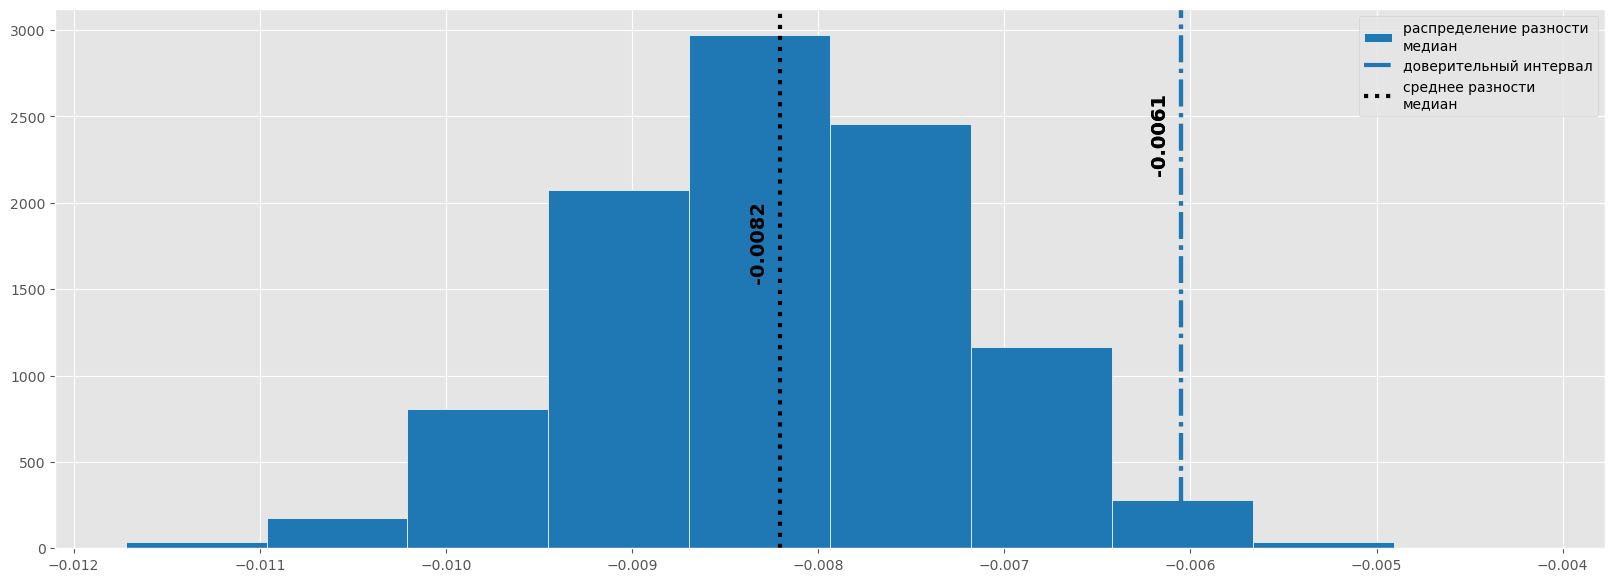

In [53]:
bootstrap_median_test(
    main_group[main_group.group_name == 'only_offline'].offline_attendance,
    main_group[main_group.group_name == 'more_offline'].offline_attendance,
    alpha=0.01, graph=True, alternative='smaller'
);

**Вывод**: таким образом, мы **отвергаем $H_0$ и принимаем $H_1$**, так как доверительный интервал находится справа от нуля. Это означает, что, действительно, онлайн-формат стимулирует посещаемость оффлайн-занятий.

#### Гипотеза №2

Следующая гипотеза гласит, что даже та группа, которая в большей мере предпочитает онлайн-формат, посещает оффлайн-занятия чаще, чем респонденты, предпочитающие исключительно оффлайн-формат. Статистически мы можем сформулировать ее следующи образом:
$$\begin{aligned}
&H_0: \ Med(X_{only\_offline}^{offline\_attendance}) \ge Med(X_{more\_online}^{offline\_attendance}) \ -\ \text{медианы групп only\_offline и more\_online по метрике \underline{offline\_attendance} равны} \\
&H_1: \ Med(X_{only\_offline}^{offline\_attendance}) < Med(X_{more\_online}^{offline\_attendance})  \ -\ \text{медиана в группе only\_offline меньше, чем в группе more\_online}
\end{aligned}$$

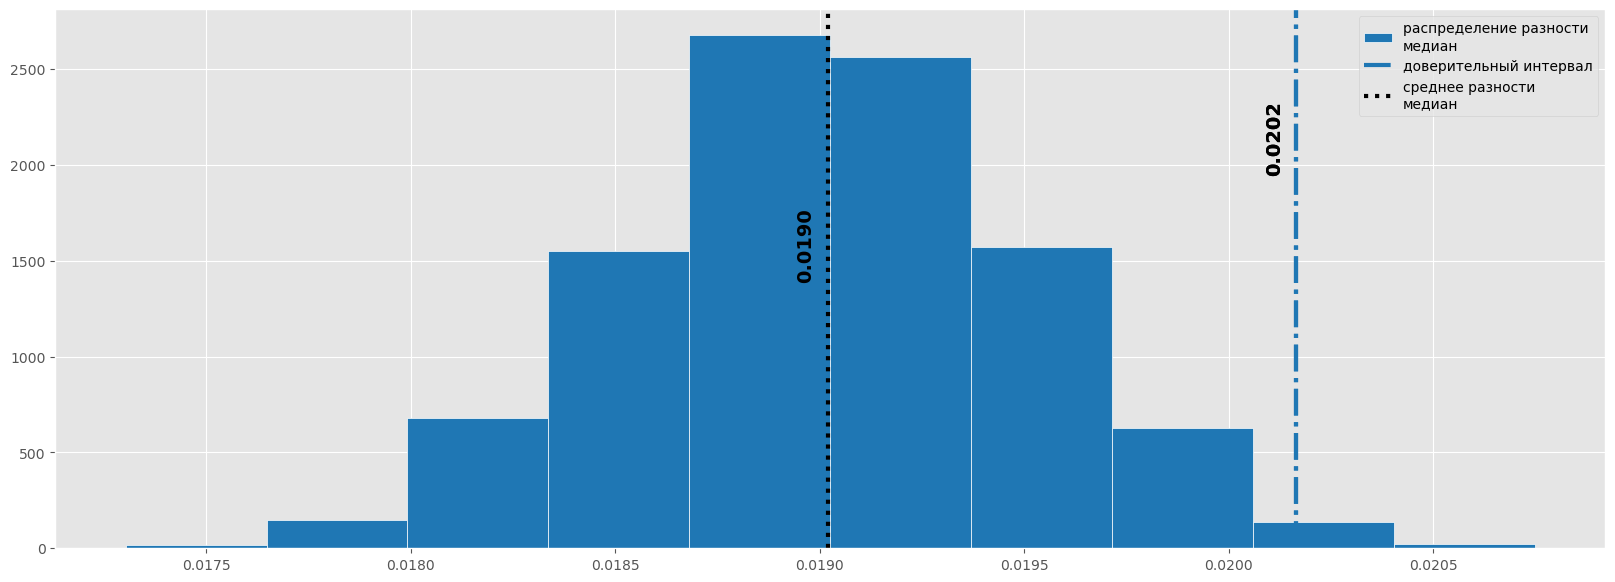

In [54]:
bootstrap_median_test(
    main_group[main_group.group_name == 'only_offline'].offline_attendance,
    main_group[main_group.group_name == 'more_online'].offline_attendance,
    alpha=0.01, graph=True, alternative='smaller'
);

**Вывод**: видим, что ноль очень далек от доверительного интервала, однако он находится слева, соответственно, можно сделать вывод, что, в группе `more_online` посещаемость оффлайн-мероприятий ниже, чем в группе `only_offline`. Таким образом, **$H_0$ не отвергается**.

#### Гипотеза №3

Данная гипотеза предполагает, что даже в качестве неосновного предпочитаемого формата, оффлайн-формат негативно сказывется на посещаемости занятий. Мы можем посмотреть на эту гипотезу под несколькими углами: с точки зрения посещаемости онлайн-занятий и с точки зрения совокупной посещаемости. Значимее для нас, очевидно эффект на совокупную посещаемость, однако так же было бы интересно рассмотреть и влияние на онлайн-посещаемость. Таким образом, отталкиваться мы будем именно от результатов по совокупной посещаемости.

Для начала проверим гипотезу для онлайн-посещаемости. Статистически мы можем сформулировать ее следующи образом:
$$\begin{aligned}
&H_0: \ Med(X_{only\_online}^{online\_attendance}) \le Med(X_{more\_online}^{online\_attendance}) \ -\ \text{медианы групп only\_online и more\_online по метрике \underline{online\_attendance} равны или медиана only\_online меньше} \\
&H_1: \ Med(X_{only\_online}^{online\_attendance}) > Med(X_{more\_online}^{online\_attendance})  \ -\ \text{медиана в группе only\_online больше, чем в группе more\_online}
\end{aligned}$$

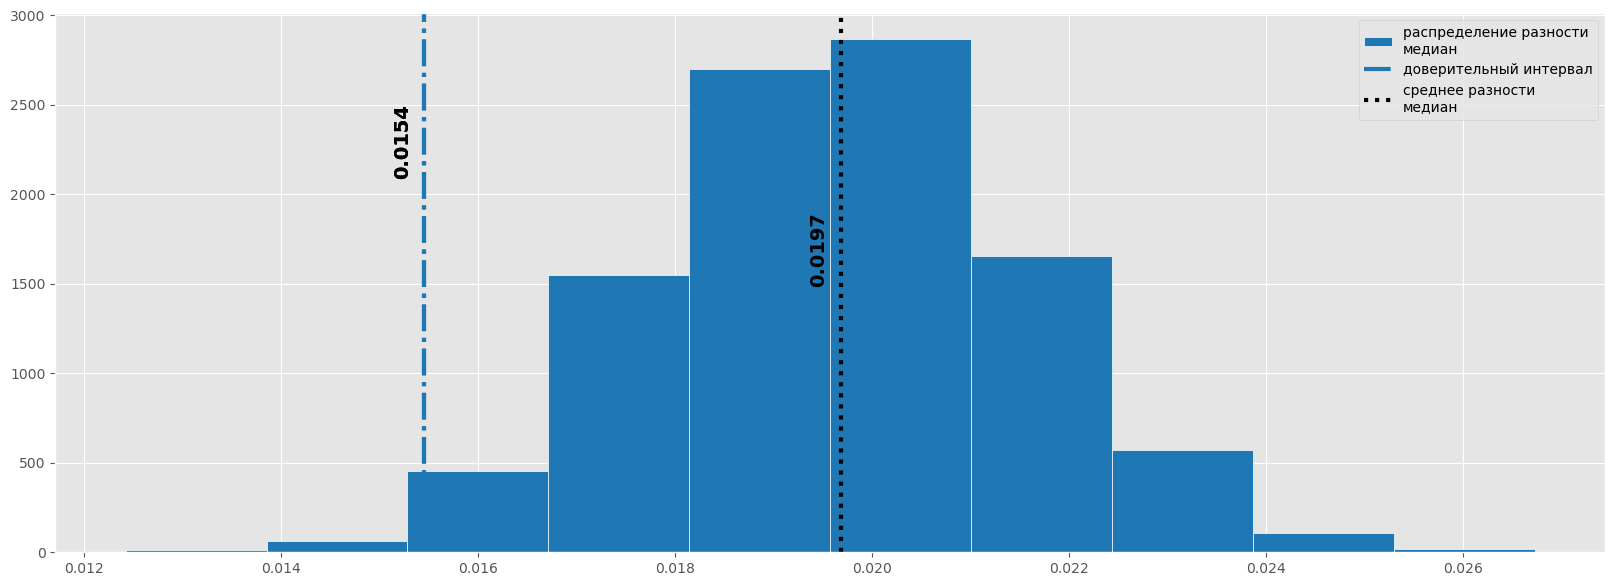

In [55]:
bootstrap_median_test(
    main_group[main_group.group_name == 'only_online'].online_attendance,
    main_group[main_group.group_name == 'more_online'].online_attendance,
    alpha=0.01, graph=True, alternative='larger'
);

**Вывод**: видим, что эффект имеется, и для группы, посещающей в том числе оффлайн-занятия, посещаемость меньше, чем в группе, посещающей исключительно онлайн-занятия. Таким образом, **$H_0$ отвергается и принимается $H_1$**.

Теперь посмотрим на совокупный эффект. Статистически гипотеза будет выглядеть следующем образом:
$$\begin{aligned}
&H_0: \ Med(X_{only\_online}^{attendance}) \le Med(X_{more\_online}^{attendance}) \ -\ \text{медианы групп only\_online и more\_online по метрике \underline{attendance} равны или медиана only\_online меньше} \\
&H_1: \ Med(X_{only\_online}^{attendance}) > Med(X_{more\_online}^{attendance})  \ -\ \text{медиана в группе only\_online больше, чем в группе more\_online}
\end{aligned}$$

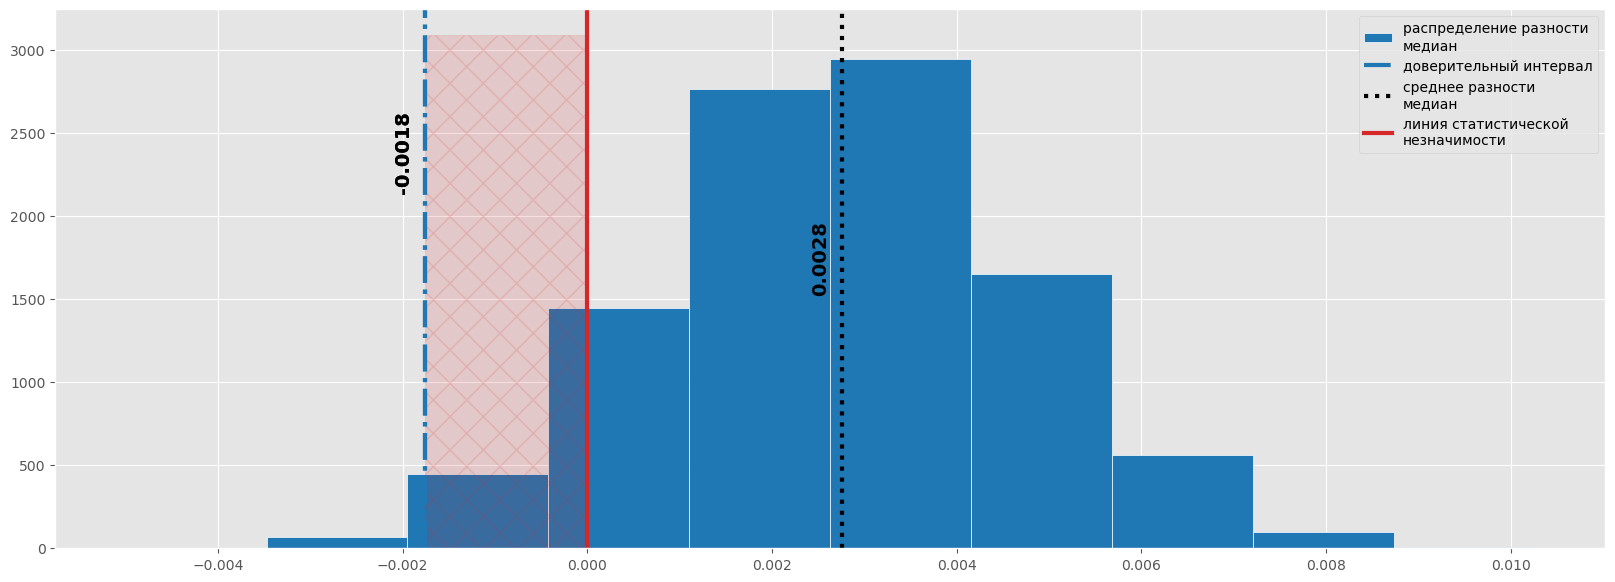

In [56]:
bootstrap_median_test(
    main_group[main_group.group_name == 'only_online'].attendance,
    main_group[main_group.group_name == 'more_online'].attendance,
    alpha=0.01, graph=True, alternative='larger'
);

**Вывод**: видим, что в доверительный интервал так же не попало нулевое значение, однако оно находится слева (меньше) от нуля, что говорит нам о том, что небольшое количество оффлайн-занятий в общем числе оказывает положительный статистически значимый эффект на совокупную посещаемость. Таким образом, **$H_0$ не отвергается**.

#### Гипотеза №4

Следующая гипотеза гласит, что онлайн-формат способствует большей совокупной посещаемости, нежели оффлайн-формат. Статистически мы можем сформулировать ее следующи образом:
$$\begin{aligned}
&H_0: \ Med(X_{only\_online}^{attendance}) \le Med(X_{only\_offline}^{attendance}) \ -\ \text{медианы групп only\_online и only\_offline по метрике \underline{attendance} равны} \\
&H_1: \ Med(X_{only\_online}^{attendance}) > Med(X_{only\_offline}^{attendance})  \ -\ \text{медиана в группе only\_online больше, чем в группе only\_offline}
\end{aligned}$$

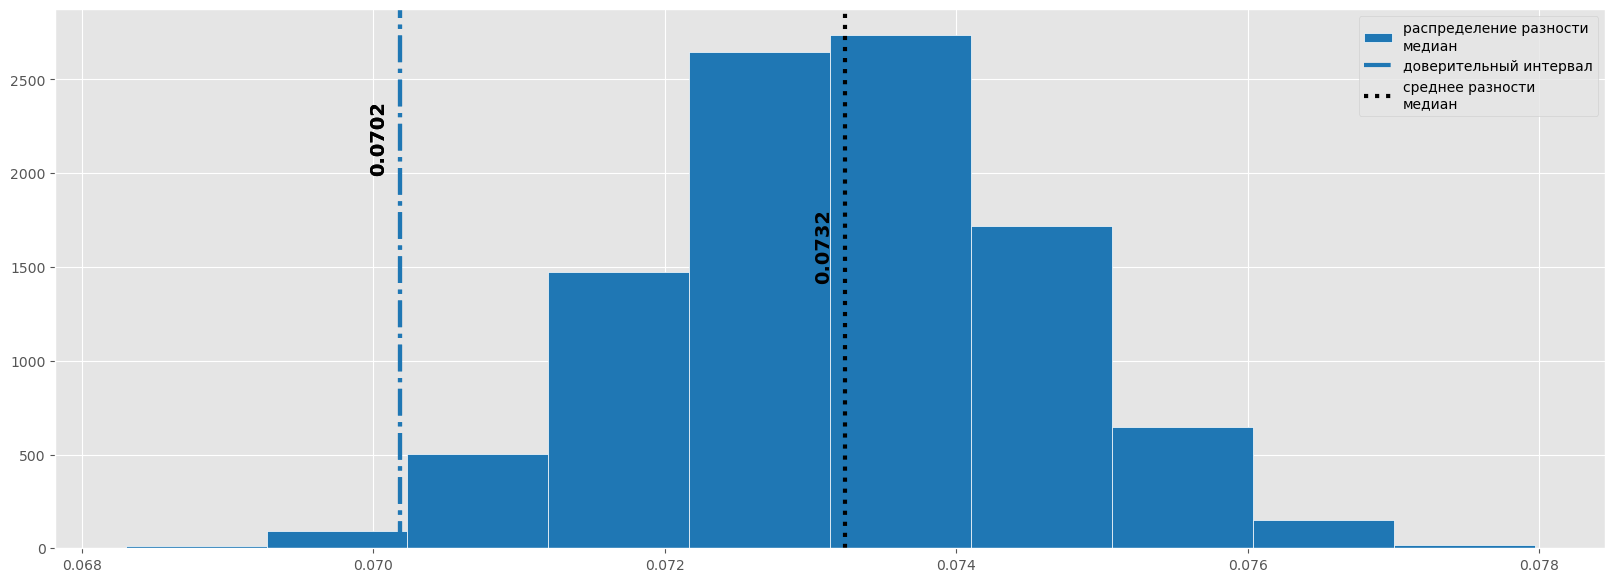

In [57]:
bootstrap_median_test(
    main_group[main_group.group_name == 'only_online'].attendance,
    main_group[main_group.group_name == 'only_offline'].attendance,
    alpha=0.01, graph=True, alternative='larger'
);

**Вывод**: действительно, гипотеза оказалась верна и для оффлайн-формата показатель совокупная посещаемости ниже, чем для занятий, проводимых в онлайн-формате. Гипотеза **$H_0$ отвергается и принимается альтернативная**.

#### Гипотеза №5

Пятая гипотеза гласит, что средний возраст в группе, предпочитающей только оффлайн-занятия, выше, чем в той, что предпочитает исключительно онлайн-формат. Статистически мы можем сформулировать ее следующи образом:
$$\begin{aligned}
&H_0: \ \mu_{only\_online}^{age} \ge \mu_{only\_offline}^{age} \ -\ \text{средние значения групп only\_online и only\_offline по метрике \underline{age} равны} \\
&H_1: \ \mu_{only\_online}^{age} < \mu_{only\_offline}^{age}  \ -\ \text{среднее в группе only\_online меньше, чем в группе only\_offline}
\end{aligned}$$

In [58]:
z_score, pval = ztest(
    main_group[main_group.group_name == 'only_online'].age,
    main_group[main_group.group_name == 'only_offline'].age,
    alternative='smaller'
)
pval

1.6136620184385037e-235

**Вывод**: очень низкое p-value говорит о том, что в группе, предпочитающей исключительно оффлайн-формат, средний возраст действительно статистически значимо выше, нежели в той, что предпочитает только онлайн-занятия.

Теперь давайте проверим ту же гипотезу, но на этот раз сравним группу `only_offline` с самой "старой" группой из оставшихся, то есть `more_offline`. Это необходимо для того, чтобы идентифицировать барьер на "вход в онлайн-формат". Под этим предполагается, что с увеличением возраста люди становятся более консервативными и противятся чему-то новому, в данном случае онлайн-форматы, по причине непоятности и новизны. Гипотеза будет иметь следуюший вид:
$$\begin{aligned}
&H_0: \ \mu_{only\_offline}^{age} \le \mu_{more\_offline}^{age} \ -\ \text{средние значения групп only\_offline и more\_offline по метрике \underline{age} равны} \\
&H_1: \ \mu_{only\_offline}^{age} > \mu_{more\_offline}^{age}  \ -\ \text{среднее в группе only\_offline больше, чем в группе more\_offline}
\end{aligned}$$

In [59]:
z_score, pval = ztest(
    main_group[main_group.group_name == 'only_offline'].age,
    main_group[main_group.group_name == 'more_offline'].age,
    alternative='larger'
)
pval

2.1491028781694402e-60

**Вывод**: действительно, p-value гораздо ниже нуля, что заставляет нас отвергнуть $H_0$ и принять альтернативную гипотезу, которая подразумевает наличие "возрастного" барьера на вход в онлайн-формат.

И наконец, давайте проверим эту же гипотезу, но теперь сравним группу `only_online` с самой "старой" группой кроме `only_offline`, то есть `more_offline`. Это нам нужно для того, чтобы понять, есть ли такой же "возрастной" барьер для наращивания доли онлайн-занятий, как для входа в онлайн-формат. То есть мы собираемся удостовериться в том, что дейстивтельно виной всему барьер на вход, а не на наращение доли:
$$\begin{aligned}
&H_0: \ \mu_{only\_online}^{age} \ge \mu_{more\_offline}^{age} \ -\ \text{средние значения групп only\_online и more\_offline по метрике \underline{age} равны} \\
&H_1: \ \mu_{only\_online}^{age} < \mu_{more\_offline}^{age}  \ -\ \text{среднее в группе only\_online меньше, чем в группе more\_offline}
\end{aligned}$$

In [60]:
z_score, pval = ztest(
    main_group[main_group.group_name == 'only_online'].age,
    main_group[main_group.group_name == 'more_offline'].age,
    alternative='smaller'
)
pval

0.05651959516377352

**Вывод**: как видим, p-значение больше 1% и приблизительно составляет 6%, соответственно, мы с достаточной уверенностью можем сказать, что **"возрастной" барьер для наращивания доли онлайн-занятий в совокупно посещенных занятиях отсутствует**. $H_0$ не отвергается.

### **Анализ активностей**

#### Визуализация

Итак, давайте проведем ABC-анализ, целью которого мы предполагаем выявление группы наиболее привлекательных для пенсионеров дисциплин. Также, в ходе анализа мы, в том числе, изучим сами дисцилины на предмет их специфики и возможности их объединения или сегрегации.

Сперва создадим удобный для дальнейших расчетов датафрейм:

In [61]:
act1 = main_group[['top1_activity_name', 'top1_activity_participate']].copy()
act2 = main_group[['top2_activity_name', 'top2_activity_participate']].copy()
act3 = main_group[['top3_activity_name', 'top3_activity_participate']].copy()

for obj in (act1, act2, act3):
    obj.columns = ['activity', 'participate']

raw_activities = pd.concat([act1, act2, act3], axis=0, ignore_index=True)

raw_activities.head()

,activity,participate
0,ONLINE English language,51
1,ONLINE Drawing,13
2,ONLINE English language,37
3,Walking lecture hall,42
4,Nordic walking,119


Теперь сгруппируем датафрейм по названию дисциплин, просуммируем количество участий по каждой, а затем отсортируем в убывающем порядке

In [62]:
abc_activities = (
    raw_activities
    .groupby('activity')
    .sum()
    .sort_values(by='participate')
)

Добавим столбец с типом формата и останится только оформить, получившийся датафрейм

In [63]:
abc_activities['format'] = np.where(abc_activities.index.str.startswith('ONLINE'), 'online', 'offline')

abc_activities.reset_index(inplace=True)
abc_activities['activity'] = abc_activities['activity'].str.removeprefix('ONLINE ')

Создадим переменную для упорядоченного отображения названий на оси ординат.

In [64]:
order = abc_activities.reset_index()
order['activity'] = order['activity'].str.removeprefix('ONLINE ')

order = (
    order
    .groupby('activity')
    .agg({'participate': 'sum'})
    .sort_values('participate')
    .index
)

Строим график

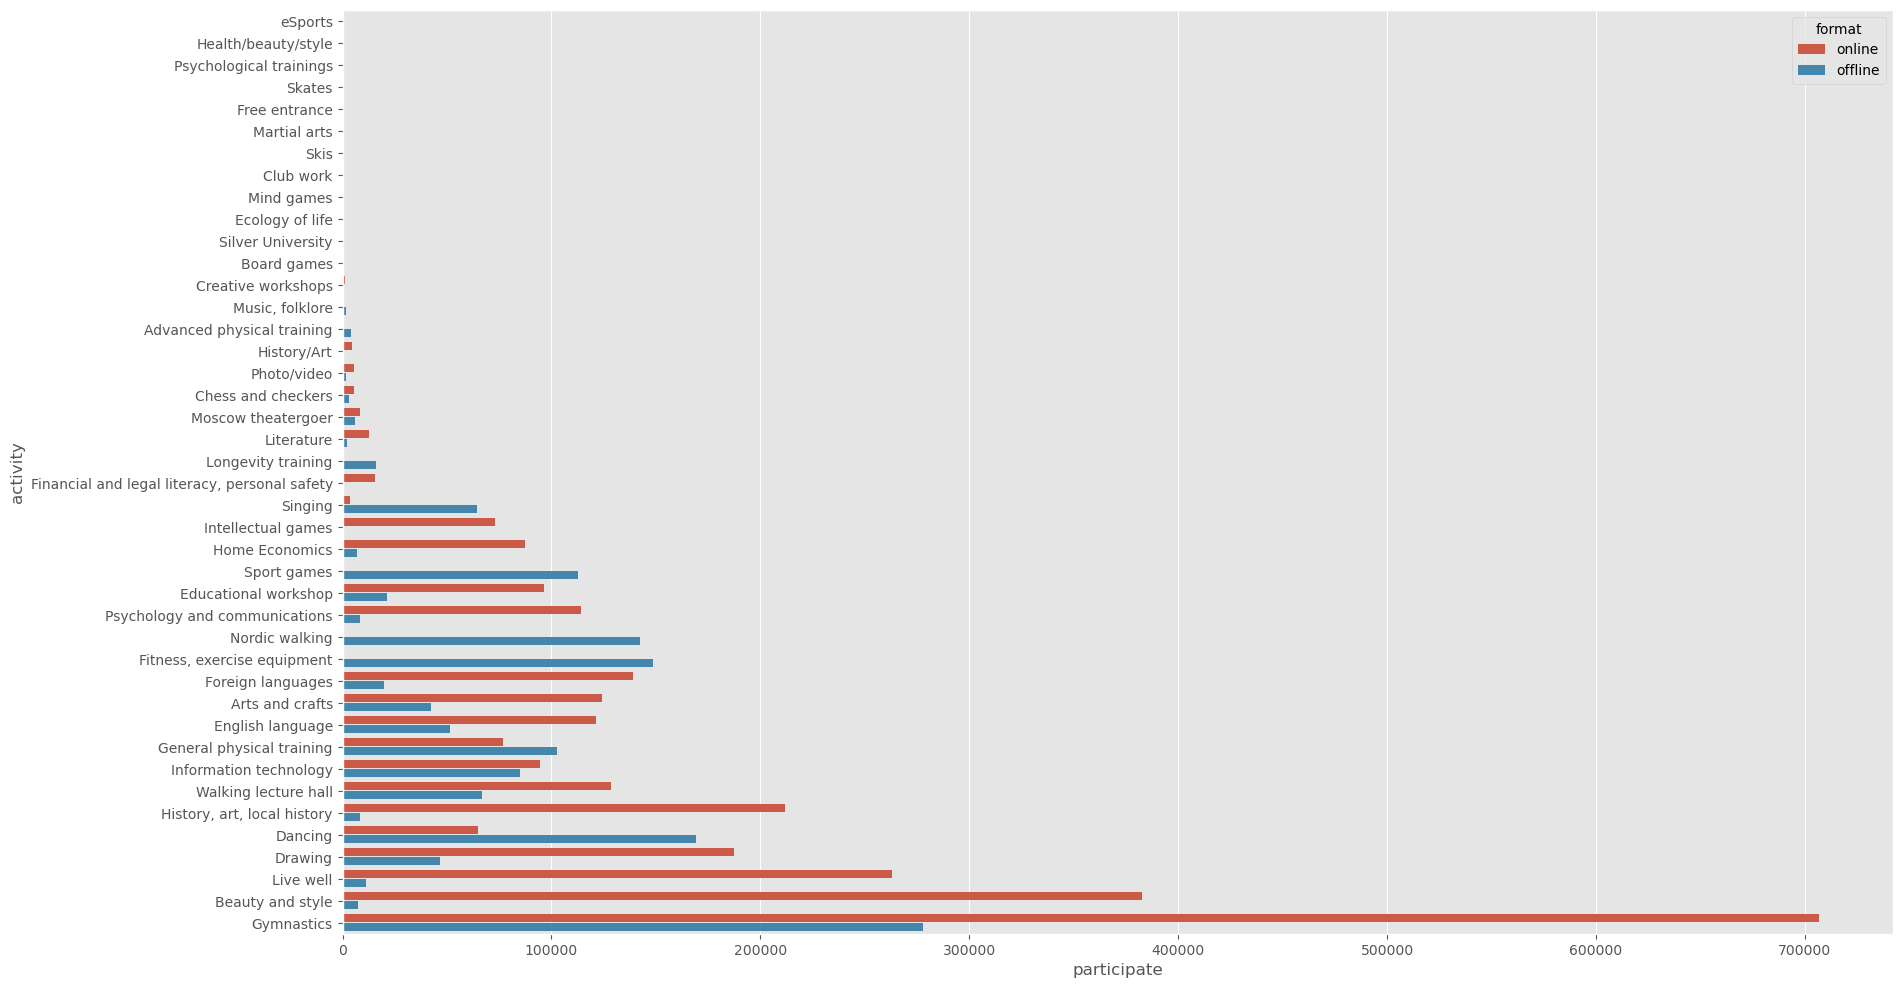

In [65]:
plt.figure(figsize=(20, 12))

sns.barplot(
    data=abc_activities, x='participate', y='activity',
    hue='format', gap=0.1, order=order
);

#### ABC-анализ

Скопируем в новую переменную сырой датафрейм и уберем префикс "ONLINE", так как при присвоении группы, нам не важен формат.

In [66]:
abc = raw_activities.copy()
abc.activity = abc.activity.str.removeprefix('ONLINE ')

abc = (
    abc
    .groupby('activity')
    .sum()
    .sort_values(by='participate')
    .reset_index()
)

In [67]:
abc['csum'] = abc.participate.cumsum() / abc.participate.sum()
abc['abc'] = np.where(abc.csum < 0.05, 'C', np.where(abc.csum < 0.2, 'B', 'A'))

abc

,activity,participate,csum,abc
0,eSports,96,0.0000,C
1,Health/beauty/style,97,0.0000,C
2,Psychological trainings,176,0.0001,C
3,Skates,202,0.0001,C
4,Free entrance,203,0.0002,C
5,Martial arts,369,0.0003,C
6,Skis,378,0.0003,C
7,Club work,520,0.0005,C
8,Mind games,566,0.0006,C
9,Ecology of life,597,0.0007,C


**Вывод**: среди результирующих дисциплин можно выделить огромное количество тех, которые либо дополняют друг друга, либо вовсе дублируют, посему было бы резонно объединить их в одну дисциплину, чтобы агрегировать целевую аудиторию, что может поспособствовать увеличению посещаемости.

#### Выявление отсутсвующих форматов по дисциплинам

In [68]:
onlines = set(abc_activities[abc_activities.format == 'online'].activity)
offlines = set(abc_activities[abc_activities.format == 'offline'].activity)

without_online = offlines - onlines
without_offline = onlines - offlines

Ниже приведен список дисциплин, для которых недоступен онлайн-формат. Большинство из них завязаны на физическом опыте. Однако присутствуют и те дисциплины, для которых было бы гораздо более логично выделить онлайн-формат занятий, среди них:
* "Mind games";
* "Ecology of life";
* "Longevity training".

In [69]:
abc[abc.activity.isin(without_online)]

,activity,participate,csum,abc
3,Skates,202,0.0001,C
4,Free entrance,203,0.0002,C
5,Martial arts,369,0.0003,C
6,Skis,378,0.0003,C
8,Mind games,566,0.0006,C
9,Ecology of life,597,0.0007,C
14,Advanced physical training,3853,0.0032,C
20,Longevity training,15911,0.0182,C
25,Sport games,112555,0.1015,B
28,Nordic walking,142363,0.1893,B


Касательно дисциплин, для которых отсутствует оффлайн-альтернатива выступают всего 2 дисциплины, обе они имеют дисциплины-аналоги с оффлайн-форматом, поэтому было бы логичнее совместить их.

In [70]:
abc[abc.activity.isin(without_offline)]

,activity,participate,csum,abc
1,Health/beauty/style,97,0.0000,C
23,Intellectual games,72928,0.0541,B


### **Рекомендации**

#### **Рекомендация №1.**

Интегрировать в занятия, проводимые в оффлайн-формате, элементы онлайна, что позволит с помощью "мягкой силы" повысить лояльность более пожилой части аудитории к онлайн-формату, то есть разрушить барьер на вход в онлайн, в следствии чего нарастить объем всех отсальных групп за счет группы `only_offline`, тем самым кратно увеличив посещаемость

#### **Рекомендация №2**.

Провести аудит оффлайн-занятий и опросить клиентов, что позволит выявить недостатки и нивелировать их, что позволит выровнять долю групп `more_offline` и `more_online`, а также увеличить посещаемость внутри группы `more_offline`

#### **Рекомендация №3.**

Провести дополнительный анализ, целью которого будет являться выявление значимости удаленности места проживания пенсионеров от места проведения оффлайн-занятий. Возможными рекомендациями дополнительного анализа могут быть:
- открытие новых филлиалов;
- таргетирование на целевую аудиторию проживающую в радиусе $R$ от места проведения оффлайн-занятий.

#### **Рекомендация №4.**

Сосредоточиться на улучшении условий программы для наиболее активных групп, то есть - `only_online` и `more_online`.

#### **Рекомендация №5**

В целях компенсирования таких недостатков как отсутсвие доступа к занятиям в одном из форматов или дублирование/сильное сходство дисциплин или низкий уровень популярности дисциплин, необходимо объединить следующие дисциплины:
* "Beauty and style" (A-rank) и "Health/beauty/style" (C-rank);
* "History, art, local history" (A-rank) и "History, art" (C-rank);
* "Live well" (A-rank) и "Longevity training" (C-rank without online);
* "Intellectual games" (B-rank without offline), "Mind games" (C-rank without online), "Board games" (C-rank) и "Chess and checkers" (C-rank);
* "Psychology and communications" (B-rank) и "Psychological trainings" (C-rank)

#### **Рекомендация №6**

Необходимо добавить онлайн-формат занятий для дисциплины "Ecology of life".

#### **Рекомендация №7**

Стоит рассмотреть возможность интеграции ознакомительных элементов разных курсов друг в друга, если они схожи по целевой аудитории, чтобы вследствие этого пенсионеры легче мигрировали с дисциплины на дисциплину. Например, есть весьма схожий по ЦА ряд дисциплин: "Home Economics", "Ecology of life", "Financial and legal literacy, personal safety", "Information technologies" - все они направлены на прогрессивную часть пенсионеров и тех, кто просто хочет чувствовать себя комфортнее и самодостаточнее в текущих реалиях мира. Именно поэтому стоит прибегнуть к совместному продвижению дисциплин внутри друг друга.